# Semantic Textual Similarity

---

# Author

    - Unai Gurbindo
    - Jaume Guasch
---

# Date
*December 22th, 2023*

---

# Statement

Use data set and description of task Semantic Textual Similarity in SemEval 2012.

Implement some approaches to detect paraphrase using sentence similarity metrics.

- Explore some lexical dimensions.
- Explore the syntactic dimension alone.
- Explore the combination of both previous.

Add new components at your choice (optional).

Already generated word or sentence embeddings models are not allowed, such as BERT.

Compare and comment the results achieved by these approaches among them and among the official results.

Send files to raco in IHLT STS Project before the oral presentation:

- Jupyter notebook: sts-[Student1]-[Student2].ipynb

- Slides: sts-[Student1]-[Student2].pdf

---
## Requeriments

The following libraries need to be installed to run the notebook.

In [9]:
!pip install nltk

In [10]:
!pip install spacy

In [11]:
!pip install pyspellchecker

In [12]:
!pip install textdistance

In [13]:
!python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the full
pipeline package name 'en_core_web_sm' instead.
     --------------------------------------- 13.6/13.6 MB 11.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [14]:
!pip install -U deep-translator

---

## Introduction

In this work, we will deal with various examples of sentences where the objective will be to achieve a metric that shows the similarity between both sentences. This problem entails significant challenges since language is not easy to model due to the large number of synonyms, similar expressions, and words with more than one meaning. Likewise, the similarity between texts has a wide range of real-world applications, such as automatic text correction or in virtual assistants and chatbots.

Therefore, in this project, we will work with a wide variety of features that can be extracted from the text to propose an efficient solution to this problem. Regarding the sentences to be used, we specifically employ the dataset and event description from the Semantic Textual Similarity task of SemEval-2012 Task 6.

Finally, in addition to the final features we will extract from the text, we will also consider options for text cleaning or preprocessing, as well as address the various strategies implemented in the event.

---
## Project Structure

This project will begin with the reading and concatenation of all the available data. Subsequently, the following structure will be followed, where four distinct phases will be carried out:

    1. Text preprocessing
    2. Feature extraction
    3. Model generation and results
    5. Conclusions

To achieve this, various functions will be developed in the same notebook to perform these tasks, allowing a comprehensive overview of the total work done. In this way, the reader can verify how all the tasks are executed. Simultaneously, theoretical explanations and reasoning will be provided as these tasks are undertaken, along with various code comments explaining what is being done at all times.

Finally, in the conclusions section, the final result obtained will be presented along with a discussion of the various outcomes.

However, before starting each of the phases, we will load all the libraries necessary for the development of the entire project, as well as the project data.

**Libraries**

In [15]:
# Libraries for File System and Google Drive Integration
import os
# from google.colab import drive

# Basic Libraries
import pandas as pd
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing Libraries
import re
from spellchecker import SpellChecker
from deep_translator import GoogleTranslator

# Features Extraction Libraries
import spacy
nlp = spacy.load('en_core_web_sm')
import nltk

## POS Tagging Libraries
nltk.download('averaged_perceptron_tagger')
from nltk.tag.perceptron import PerceptronTagger

## WordNet Libraries for Synset and Lesk
nltk.download('wordnet')
from nltk.wsd import lesk
nltk.download('omw-1.4')
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('wordnet_ic')
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic
brown_ic = wordnet_ic.ic('ic-brown.dat')


# Libraries for features similarity computation 
import textdistance as td
from nltk.metrics import jaccard_distance

# Libraries for features scaling and model training
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.ensemble import VotingRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# Libraries for evaluation
from scipy.stats import pearsonr

# Libraries for saving and loading models
from joblib import dump, load

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\unaig\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\unaig\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\unaig\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\unaig\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\unaig\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet_ic to
[nltk_data]     C:\Users\unaig\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet_ic is already up-

**Data upload**

In this section, the reading and concatenation of all available data are performed for subsequent use. It is important to note that one of the files encountered errors when attempting to open it with the `pandas` library. To address this issue, a reading process was implemented using `Python` commands, followed by the conversion of those files into `pandas` dataframes. 

It should also be noted that some duplicate rows were identified in both the content and the ratings of these dataframes, and these duplicates were subsequently removed.

In [16]:
# drive.mount('/content/drive')
# notebook_path_unai = '/content/drive/My Drive/MAI/1.Hilekoa/IHLT Project/'
# os.chdir(notebook_path_unai)

In [17]:
# Read Files in Data Folder: test-gold.tgz, train.tgz

# Unzip Files
# !tar -xzf ./Data/test-gold.tgz
# !tar -xzf ./Data/train.tgz

# Set paths for train and test data
train_path = './train'
test_path = './test-gold'


######################################----Train----###############################################################################
# Read Train files
train_files = ["MSRpar", "MSRvid", "SMTeuroparl"]
train_data = pd.DataFrame(columns=['Sentence 1', 'Sentence 2', 'GS', 'Origin'])

for file in train_files:
    # Read input sentences
    sentences_path = train_path + '/STS.input.' + file + '.txt'
    # Read file and split by lines
    with open(sentences_path, 'r') as f:
        sentences = f.read().splitlines()
        sentences = [s.split('\t') for s in sentences]
    # Create dataframe with sentences
    input_sentences = pd.DataFrame(sentences, columns=['Sentence 1', 'Sentence 2'])
    # Read gold scores
    input_gold_score = pd.read_table(train_path + '/STS.gs.' + file + '.txt', names=['GS'])

    # Concatenate input sentences and gold scores
    input_data = pd.concat([input_sentences, input_gold_score], axis=1)
    input_data['Origin'] = file[:-4]
    # Concatenate with the overall train_data
    train_data = pd.concat([train_data, input_data], ignore_index=True)
# Remove duplicate rows based on 'Sentence 1', 'Sentence 2', 'GS'
train_data.reset_index(inplace=True)
train_data.drop_duplicates(subset=['Sentence 1', 'Sentence 2', 'GS'], keep=False, inplace=True)

# Extract the target variable and remove unnecessary columns
train_target = train_data['GS']
train_data.drop(columns=['index', 'GS'], inplace=True)

######################################----Train----###############################################################################

######################################----Test----###############################################################################
# Read test files
test_files = ["MSRpar", "MSRvid", "SMTeuroparl", "surprise.OnWN", "surprise.SMTnews"]
test_data = pd.DataFrame(columns=['Sentence 1', 'Sentence 2', 'GS', 'Origin'])
for file in test_files:
    # Read input sentences
    sentences_path = test_path + '/STS.input.' + file + '.txt'
    # Read file and split by lines
    with open(sentences_path, 'r') as f:
        sentences = f.read().splitlines()
        sentences = [s.split('\t') for s in sentences]
    # Create dataframe with sentences
    input_sentences = pd.DataFrame(sentences, columns=['Sentence 1', 'Sentence 2'])
    # Read gold scores
    input_gold_score = pd.read_table(test_path + '/STS.gs.' + file + '.txt', names=['GS'])

    # Concatenate input sentences and gold scores
    input_data = pd.concat([input_sentences, input_gold_score], axis=1)
    input_data['Origin'] = file[:-4]

    # Concatenate with the overall test_data
    test_data = pd.concat([test_data, input_data], ignore_index=True)

# Remove duplicate rows based on 'Sentence 1', 'Sentence 2', 'GS'
test_data.reset_index(inplace=True)
test_data.drop_duplicates(subset=['Sentence 1', 'Sentence 2', 'GS'], keep=False, inplace=True)

# Extract the target variable and remove unnecessary columns
test_target = test_data['GS']
test_data.drop(columns=['index', 'GS'], inplace=True)
######################################----Test----###############################################################################

In [18]:
# Create a 'result' folder if it doesn't exist
result_folder = './result'
os.makedirs(result_folder, exist_ok=True)

In [19]:
# Save train_data to CSV
train_data.to_csv(os.path.join(result_folder, 'train_data.csv'), index=False)

# Save test_data to CSV
test_data.to_csv(os.path.join(result_folder, 'test_data.csv'), index=False)

# Save train_target to CSV
train_target.to_csv(os.path.join(result_folder, 'train_target.csv'), index=False)

# Save test_target to CSV
test_target.to_csv(os.path.join(result_folder, 'test_target.csv'), index=False)


---
### Pre-processing strategies

We will begin with the first section, text preprocessing. This phase is crucial in any artificial intelligence task. Therefore, a thorough preprocessing will be conducted to reduce errors in our texts.

The initial step involves eliminating potential noise such as strange characters (like ~ or #). Additionally, several instances have been identified where a word in one sentence was enclosed in < > while in another sentence it was not, leading to the decision to remove these as well.

Furthermore, normalization will be applied to both monetization symbols and common English abbreviations across all sentences `(e.g., 're → are)`. These concepts were derived from the article `Takelab: Systems for measuring semantic text similarity` (Šarić et al., 2012) in the preprocessing section.

In [20]:
def clean_text(sentence):

    # We have seen that some sentences were in some strange enconding and that one of the datasets had some weird index with < and > signs, so we unified the encoding and removed those signs.
    sentence = re.sub(r"<\.?(.*?)>", r"\1", sentence)

    # Remove strange symbols as well as vertical bars, asterisks or strange symbols. Remove:
    sentence = re.sub(r"[&*@\\^_`{|}~#-.]", "", sentence)

    # Normalize various currency money symbols
    currency_symbols = {
    r"\b(?:dollar|dollars)\b": "$",           # Convert "dollar" or "dollars" to "$"
    r"\b(?:euro|euros)\b": "€",         # Convert "euro" or "euros" if preceded by "€" to "€"
    r"\b(?:pound|pounds)\b": "£",       # Convert "pound" or "pounds" if preceded by "£" to "£"
    r"(?<=\$)US\b": "$",                       # Normalize "$US" to "$"
    r"\b(?:yen|yens)\b": "¥",                # Convert "Yen" if preceded by "¥" to "¥"
    r"\b(?:cent|cents)\b": "¢"               # Convert "Cents" if preceded by "¢" to "¢"
    }

    # Normalize various currency numeric symbols
    numeric_symbols = {
    r"\b(\d+)K\b": "thousand",
    r"\b(\d+)M\b": "million",
    r"\b(\d+)B\b": "billion",
    r"\b(\d+)T\b": "trillion"
    }

    # Normalize various currency grammar symbols
    substitutions = {
    r"n\'t": " not",
    r"\'re": " are",
    r"\'s": " is",
    r"\'ll": " will",
    r"\'t": " not",
    r"\'ve": " have",
    r"\'m": " am",
    }

    # Combine all dictionaries
    combined_dict = currency_symbols.copy()
    combined_dict.update(numeric_symbols)
    combined_dict.update(substitutions)

    # Normalize symbols
    for pattern, replacement in combined_dict.items():
        sentence = re.sub(pattern, replacement, sentence, flags=re.IGNORECASE)

    # We also remove the double spaces that may have been created
    sentence = re.sub(r'\s+', ' ', sentence).strip()

    return sentence

In [21]:
# Clean train data
train_data_clean = train_data.copy()
train_data_clean['Sentence 1'] = train_data_clean['Sentence 1'].apply(lambda x: clean_text(x))
train_data_clean['Sentence 2'] = train_data_clean['Sentence 2'].apply(lambda x: clean_text(x))

In [22]:
# Clean test data
test_data_clean = test_data.copy()
test_data_clean['Sentence 1'] = test_data_clean['Sentence 1'].apply(lambda x: clean_text(x))
test_data_clean['Sentence 2'] = test_data_clean['Sentence 2'].apply(lambda x: clean_text(x))

In [23]:
# Save train_data_corrrected to CSV
train_data_clean.to_csv(os.path.join(result_folder, 'train_data_clean.csv'), index=False)

# Save test_data_clean to CSV
test_data_clean.to_csv(os.path.join(result_folder, 'test_data_clean.csv'), index=False)

Then, before starting to extract features, as we have already mentioned, we see the vital importance of the need to preprocess the text. Probably, with several of the metrics we use, we will encounter cases where the error of a single letter in a word causes the loss of information about the similarity between sentences because those words will no longer be equal.

Therefore, we have decided to run a spell checker on the sentences, which will correct misspelled words with the correct ones whenever possible in addition to the clean-up we have already generated. To do this, we will use the `spellchecker` library in Python, which comes with an integrated corrector. 

In the following *example*, we demonstrate how we use the library's corrector to rectify potential errors in the words of a sentence. In this instance, there are three misspelled words: `{'sentennce', 'examplo', 'wordds'}`, which are ultimately corrected.

*Example*

In [24]:
# Create a SpellChecker instance
spell = SpellChecker(distance=3)

# Example text with some intentional spelling errors
text = "this is an examplo sentennce with some misspelled wordds"

# Split the text into words
words = text.split()

# Find and print misspelled words
misspelled = spell.unknown(words)
print("Misspelled words:", misspelled)

# Correct the misspelled words
for word in misspelled:
    corrected_word = spell.correction(word)
    text = text.replace(word, corrected_word)

print("Corrected text:", text)

Misspelled words: {'examplo', 'sentennce', 'wordds'}
Corrected text: this is an example sentence with some misspelled words


Therefore, we generate a function that implements this corrector and corrects the sentences in our text.

In [25]:
def correct_sentences(sentence):
    # Create a SpellChecker instance
    spell = SpellChecker()

    # Split the text into words
    words = sentence.split()

    # Find misspelled words
    misspelled = spell.unknown(words)

    # Correct the misspelled words
    for word in misspelled:
        try:
          corrected_word = spell.correction(word)
          sentence = sentence.replace(word, corrected_word)
        except:
          pass
        
    return sentence

In [26]:
# Correcting train data
train_data_corrrected = train_data_clean.copy()
train_data_corrrected['Sentence 1'] = train_data_corrrected['Sentence 1'].apply(lambda x: correct_sentences(x))
train_data_corrrected['Sentence 2'] = train_data_corrrected['Sentence 2'].apply(lambda x: correct_sentences(x))

# We apply again the cleaning of the data in case the corrector has included by any chance some strange symbol.
train_data_corrrected['Sentence 1'] = train_data_corrrected['Sentence 1'].apply(lambda x: clean_text(x))
train_data_corrrected['Sentence 2'] = train_data_corrrected['Sentence 2'].apply(lambda x: clean_text(x))

In [27]:
# Correcting test data
test_data_corrrected = test_data_clean.copy()
test_data_corrrected['Sentence 1'] = test_data_corrrected['Sentence 1'].apply(lambda x: correct_sentences(x))
test_data_corrrected['Sentence 2'] = test_data_corrrected['Sentence 2'].apply(lambda x: correct_sentences(x))

# We apply again the cleaning of the data in case the corrector has included by any chance some strange symbol.
test_data_corrrected['Sentence 1'] = test_data_corrrected['Sentence 1'].apply(lambda x: clean_text(x))
test_data_corrrected['Sentence 2'] = test_data_corrrected['Sentence 2'].apply(lambda x: clean_text(x))

In [28]:
# Save train_data_corrrected to CSV
train_data_corrrected.to_csv(os.path.join(result_folder, 'train_data_corrrected.csv'), index=False)

# Save test_data_corrrected to CSV
test_data_corrrected.to_csv(os.path.join(result_folder, 'test_data_corrrected.csv'), index=False)

Finally, to conclude this section, we will carry out a procedure that slightly deviates from the scope of the section: **Data Augmentation**.

We include this phase in this section because, in the end, we are preparing data that we will use later in our models.

However, how can we approach **Data Augmentation** in this problem?

Well, as proposed in the article `Ukp: Computing semantic textual similarity by combining multiple content similarity measures` (Bar et al., 2012) in the Statistical Machine Translation section, they rely on translating the sentences into another language. In our case, we have selected Spanish, and then we translate it back into English.

In this way, the sentences, when translated back into English, may not be identical, but they will have the same meaning. This provides more instances for our future models.

Therefore, in this case, to perform this translation task, we have utilized the `deep_translator` library. Thanks to this library, we can create translators from English to Spanish and from Spanish to English, as demonstrated in the following example, where a new sentence with the same meaning but different words is generated from an original phrase.

*Example*

In [29]:
sentence= "keep it up, you are awesome"

sentence_translate_es=GoogleTranslator(source='auto', target='es').translate(sentence) 
GoogleTranslator(source='auto', target='en').translate(sentence_translate_es) 

"keep it up you're great"

Likewise, thanks to this example, we realized that it was necessary to apply the cleaning function we developed at the beginning of the section to both the translator's output and the spell checker. This is because they could introduce some issues, as illustrated in this example where an abbreviated verb such as `'re'` is included.

In [30]:
def translate_sentences(sentence):
    try:
        # Translate to spanish 
        sentence_translate_es=GoogleTranslator(source='auto', target='es').translate(sentence) 
        # Translate to english
        sentence_translate_en=GoogleTranslator(source='auto', target='en').translate(sentence_translate_es) 
        return sentence_translate_en
    except:
        # If there is any error, we return the original sentence
        return sentence

In [31]:
data_augmentation = train_data_corrrected.copy()
data_augmentation['Sentence 1'] = data_augmentation['Sentence 1'].apply(lambda x: translate_sentences(x))
data_augmentation['Sentence 2'] = data_augmentation['Sentence 2'].apply(lambda x: translate_sentences(x))
# We apply again the cleaning of the data in case the corrector has included by any chance some strange symbol.
data_augmentation['Sentence 1'] = data_augmentation['Sentence 1'].apply(lambda x: clean_text(x))
data_augmentation['Sentence 2'] = data_augmentation['Sentence 2'].apply(lambda x: clean_text(x))

In [32]:
# Save train_data_corrrected to CSV
data_augmentation.to_csv(os.path.join(result_folder, 'data_augmentation.csv'), index=False)

---
### Feature extraction



After the text preprocessing, we begin this new section where we will implement the most important functions of our project: the feature extraction functions. Regarding these functions, both lexical and synthetic variables will be constructed, and their development will be analyzed separately in the next section. Therefore, for now, we will simply focus on defining both the variables we extract and the similarity functions we will apply to them.

To start with the variables that we can extract from the sentences, we will undergo various processes with the phrases, after which we will calculate different set similarities. These metrics will be the values that we will introduce into our model.

As for the first process that will be carried out on the sentences, it does not exactly involve feature extraction but rather converting all words to lowercase. This process, like the removal of stopwords, might seem like it should be part of text preprocessing. However, there will be extraction functions where we prefer to keep the letters in uppercase to avoid potential issues, such as when working with entities where putting everything in lowercase may not capture the entity correctly. Therefore, both this process and the removal of stopwords will be performed based on the extraction requirements.

Continuing with the function to convert sentences to lowercase, it's important to note that if not done, information is generally lost (if there are two identical words but one is written with the first letter in uppercase, they will not be considered equal, leading to information loss). This was illustrated in the second lab session with the following example.

*Example*

> If we compare the sentences "Supermarkets are great, that is why I love them." and "I love supermarkets because they are great." We see that if we use uppercase words as well, "supermarkets" and "Supermarkets" are different words, while they are the same when we only use lowercase words.

Therefore, we proceed to generate the function that performs this process called `sentences_to_lower`. This function makes use of the ´lower()´ function available for string variables in python.

In [33]:
def sentences_to_lower(sentence):
  # Converts a sentence to lowercase.
  return sentence.lower()

Then, we start creating the functions that will actually provide us with the information to later calculate the similarity between two sentences.

To generate these variables, we have used both all the deliverables from the conducted labs and several articles published in the competition of the problem (Šarić et al., 2012, Bar et al., 2012).

Next, the features that will be extracted are named and described.

#### Lemmatisation and tokenisation

The first phase we are going to develop is both tokenisation and lemmatisation. Both will be carried out by allowing to eliminate or not the empty words (stopwords) contained in the sentences. Remember that these strategies were analysed in both the second and third labs of this subject.

It is important to remember that lemmas are the basic form of a word, so in lemmatisation, the sentence is separated into words reduced to their root, while in tokenisation, the sentence is simply separated into the different words.

It is worth mentioning that empty words, as we have already seen in several labs, are those words with no meaning of their own that can distort the true similarity between words, and so in the vast majority of cases we will eliminate them.

We generate the functions that will allow us to carry out these operations:

In [34]:
def get_lemmas(sentence, remove_stopwords):
  # Returns the lemmas of a sentence.
  
  # Tokenize the sentence  
  doc = nlp(sentence)
  tokens = []
  for token in doc:
      # Check remove_stopwords
      if remove_stopwords and token.is_stop:
          continue
      # Check remove_punctuation
      if token.is_punct:
          continue
      tokens.append(token.lemma_) # Get the lemma of the token
  return tokens

def get_tokens(sentence, remove_stopwords):
  # Returns the tokens of a sentence.
  
  # Tokenize the sentence
  doc = nlp(sentence)
  tokens = []
  for token in doc:
      # Check remove_stopwords
      if remove_stopwords and token.is_stop:
          continue
      # Check remove_punctuation
      if token.is_punct:
          continue
      tokens.append(token.text) # Get the text of the token
  return tokens

The above functions make use of the `spacy` library and the `nlp` model (this model will be used in most functions) to carry out the process. 

#### Senses

The next extraction we will develop will be to obtain the meaning of each of the words, as we did in lab 6. 

In addition, we will implement another function called `get_words_from_definitions` in which we will not only get the meaning but also the meaning associated to that meaning.

For tagging we get the `PerceptronTagger` model, because as we could see in that lab session it was the best option we tried.  Then, the `lesk` algorithm (available on the wordnet in the `nltk` library) is used to obtain the meaning based on the word tag, the word and the complete sentence. 

The functions that generate this transformation are shown below.

In [35]:
# Importing the PerceptronTagger class to tag the words
tagger = PerceptronTagger()

# Mapping POS tags to simplified POS categories
d = {
    'NN': 'n', 'NNS': 'n', 'NNP': 'n', 'NNPS': 'n',
    'JJ': 'a', 'JJR': 'a', 'JJS': 'a',
    'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v',
    'RB': 'r', 'RBR': 'r', 'RBS': 'r'
}

def get_senses(sentence): 
    # Function to get WordNet senses for each word in a sentence
    
    # Tokenizing the sentence without stopwords
    split_sentence = get_tokens(sentence, True)
    # Performing part-of-speech tagging
    tagged_sentence = tagger.tag(split_sentence)
    senses = []

    # Looping through each word and its POS tag
    for word, pos in tagged_sentence:
        # Mapping POS tag to simplified POS category
        pos = d.get(pos, None)
        if pos:
            # Getting WordNet sense using Lesk algorithm
            sense = lesk(sentence, word, pos)
            if sense:
                senses.append(sense.name())

    return senses

def get_words_from_definitions(sentence):
    # Function to get words from the definitions of senses in a sentence

    # Tokenizing the sentence without stopwords
    split_sentence = get_tokens(sentence, True)
    
    # Performing part-of-speech tagging
    tagged_sentence = tagger.tag(split_sentence)
    words_from_defs = set()

    # Looping through each word and its POS tag
    for word, pos in tagged_sentence:
        # Mapping POS tag to simplified POS category
        pos = d.get(pos, None)
        if pos:
            # Getting WordNet sense using Lesk algorithm
            sense = lesk(sentence, word, pos)
            if sense:
                # Get words from the definition of the sense
                definition = sense.definition()
                definition_split = get_tokens(definition, True)
                definition_words = set(definition_split)
                words_from_defs.update(definition_words)

    return words_from_defs

#### Entities

We continue with other transformations and now we build on the one from lab 7, so now we make use of the name entities that are available in the sentences. 

As we said in that lab, this can be an interesting form of analysis as reducing words to the entity they belong to can help to capture similarities. 

Recall that Name Entities are real-world objects that have names, such as people, organisations, places, dates, numerical values, etc. 

The following function (`get_entity_token`) groups the tokens that are not stopwords of the phrase according to the entities they belong to, for example Mr. Jaume instead of taking it separately now we would be taking it together.

In [36]:
def get_entity_token(sentence):
    
    doc = nlp(sentence)
    
    # Merge entities into one token
    with doc.retokenize() as retokenizer:
        for ent in doc.ents:
            retokenizer.merge(ent)
    
    # Get tokens (words)    
    tokens = [token.text.lower() for token in doc if not token.is_stop]
    return tokens

Now, what will probably help us the most as we saw in that report will be the use of the entity to which these words belong, so this is extracted thanks to the function `get_entitys`.

In [37]:
def get_entitys(sentence):
    
    doc = nlp(sentence)
    
    # Merge entities into one token
    with doc.retokenize() as retokenizer:
        for ent in doc.ents:
            retokenizer.merge(ent)
    
    # Get entities (entities)
    tokens = [token.ent_type_ for token in doc]
    # Remove empty tokens (tokens == "")
    tokens = list(filter(None, tokens))
    return tokens

#### N-Grams

Next, we move on to do something we did not do in the previous lab practicals, the ngrams. In short, based on the paper `UKP: Computing Semantic Textual Similarity by Combining Multiple Content Similarity Measures` (Bar et al., 2012), we decided to calculate the ngrams with characters and with words.

In short, an n-gram is a contiguous sequence of n elements of a given sentence, these elements can be word or character-like.

*Example Bigrams (2-grams)*

    - Sentence: "The quick brown fox jumps."
    - 2-grams: "The quick", "quick brown", "brown fox", "fox jumps"

This will be done for n equal to 2, 3 and 4. Moreover, it will be done both with and without stopwords.

In [38]:
# Ngrams words and characters
def word_ngrams(sentence, n, remove_stopwords):
    # Get tokens
    tokens=get_tokens(sentence, remove_stopwords)
    # Retirm words ngrams
    return [" ".join(gram) for gram in list(nltk.ngrams(tokens,n))]

def character_ngrams(sentence, n, remove_stopwords):
    # Return character ngrams
    return ["".join(gram) for gram in list(nltk.ngrams(sentence,n))]

The above functions make use of the function for obtaining tokens defined above and the `ngrams` function of the `nltk` library to perform the extraction of the ngrams.

#### POS tags and N-Grams

We also included an extraction based on the n-grams that we have just learned about and the labeling from laboratory session 4. Initially, we had planned to simply extract the part-of-speech tagging for each word (`get_pos_tags`). However, after considering the ideas we have read, we came to the conclusion that it would be useful to generate n-grams along with their corresponding part-of-speech tags (`get_pos_tags_ngrams`).

To create these functions, we based ourselves on the code from the previous functions for n-grams and the one for senses to obtain the part-of-speech (POS) tags.

In [39]:
def get_pos_tags(sentence, remove_stopwords):
    # Get tokens withou stopwords
    split_sentence = get_tokens(sentence, True)
    # Get POS tags
    tagged_sentence = tagger.tag(split_sentence)
    # Return POS tags
    return [tuple[1] for tuple in tagged_sentence]

def get_pos_tags_ngrams(sentence,n):
    # Get tokens with stopwords. We inlcude stopwords because we want to know the use of stopwords in sentence structure
    split_sentence = get_tokens(sentence, False)
    # Get POS tags
    tagged_sentence = tagger.tag(split_sentence)
    # Get POS tags ngrams
    pos = [tuple[1] for tuple in tagged_sentence]
    # Return POS tags ngrams
    return [" ".join(gram) for gram in list(nltk.ngrams(pos,n))]

#### Synsents

To finish with the feature extraction of the sentences, we decided to extract the synsents that each of the words in the sentences has.

To extract the synsets we again use the `lesk` algorithm and the `synsets` of `wordnet`.

In [40]:
# In this we use the lemmatizer of nltk 
wnl = nltk.stem.WordNetLemmatizer()

def lemmatize(p):
    d = {'NN': 'n', 'NNS': 'n',
    'JJ': 'a', 'JJR': 'a', 'JJS': 'a',
    'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v',
    'RB': 'r', 'RBR': 'r', 'RBS': 'r'}
    if p[1] in d:
        return wnl.lemmatize(p[0], pos=d[p[1]]).lower()
    return p[0].lower()

def synset_extract(sentence):
    # Function to get WordNet synsets for each word in a sentence
    
    # Tokenizing the sentence without stopwords
    split_sentence = get_tokens(sentence, True)
    # Performing part-of-speech tagging
    tagged_sentence = tagger.tag(split_sentence)
    synsets = []

    # Looping through each word and its POS tag
    for lemma, pos in tagged_sentence:
        try:
            # Taking the synsets of the word
            synset =  wn.synsets(lemma, pos=lemmatize(pos))
            if len(synset) > 0:
                synsets.append(synset)
        except:
            pass
                
    return synsets

After implementing the functions that will extract features from our texts, we proceed to develop the metrics. Through these similarities and metrics that we develop, we will obtain numerical characteristics that will be used to generate models in the following section.

#### Similarities and metrics

##### Similarities between sets

Let's start by defining several similarities that we are already familiar with from all the previous laboratory sessions we have conducted. These similarities are based on set comparisons. The Jaccard, Dice, Overlap, and Cosine similarities are developed. Regarding the first three, these are obtained using the `textdistance` library, which has implemented these similarities. However, to work with Jaccard similarity, we use the `nltk` function `jaccard_distance`, which provides a **distance** rather than a **similarity**. Therefore, to obtain the similarity, we subtract the Jaccard distance from 1. The following code cells show the functions with the similarities.

**Jaccard similarity**

In [41]:
def jaccard_sim(A,B):
  return 1 - jaccard_distance(set(A), set(B))

**Dice similarity**

In [42]:
def dice_sim(A,B):
  return td.sorensen(set(A), set(B))

**Cosine similarity**

In [43]:
def cosine(A,B):
  return td.cosine(set(A), set(B))

**Overlap similarity**

In [44]:
def overlap(A,B):
  return td.overlap(set(A), set(B))

> We have also implemented several other metrics to obtain information that we consider useful. Each of them is shown and defined below.

##### Other similarities and metrics

**Intersection of two sets**

We develop the function that calculates the number of non-repeating elements found within two sets. We think this can be interesting in cases where we want to see how many common entities there are between two sentences.

In [45]:
def intersection_length(A, B):
    return len(set(A).intersection(set(B)))

**Difference in length**

Calculate the difference of elements between one list and another. For example, this could be useful when you have lists with lemmas without stopwords and one list has many more words than the other which could indicate that the sentences are not similar.

In [46]:
def l_difference(A, B):
    return abs(len(set(A)) - len(set(B)))/max(len(set(A)), len(set(B)))

**Number of equal elements in the list**

Count the number of elements that are the same in both lists taking into account the repetition of words.

In [47]:
def count_same(A, B):
    count = 0
    for word in A:
        if word in B:
            count += 1            
    return count/max(len(A), len(B))  

**Longest Common Subsequence and Longest Common Substring**

Then, as we saw in the winning paper (Bar et al., 2012), they made use of Longest Common Subsequence and Longest Common Substring. Therefore, we have decided to implement these two metrics which we will use after performing the `lemmatisation`.

Starting with Longest Common Subsequence, this is defined as the longest subsequence that is shared by all sequences in a set of sequences. It differs from Longest Common Substring where it is not constrained to occupy consecutive positions within the original sequences.

In [48]:
def longest_commonsubsequence(A, B): 
    if len(A) == 0 or len(B) == 0:  # Base case: If either of the sequences is empty, the LCS length is 0
        return 0
    elif A[-1] == B[-1]:  # Check if the last elements of both sequences match
        return 1 + longest_commonsubsequence(A[:-1], B[:-1])  # If they match, add 1 to the LCS length and recur for the remaining subsequences
    else:
        # If the last elements do not match, find the maximum LCS length by excluding one element at a time
        # Recur for both subsequences by excluding the last element from either A or B
        return max(longest_commonsubsequence(A, B[:-1]), longest_commonsubsequence(A[:-1], B))

def LCSubSeq(A, B):    
    return longest_commonsubsequence(A, B) / max(len(A), len(B))

As for the Longest Common Substring, as we have already mentioned, it is the longest common substring of two or more strings, it is the longest string that is a substring of all of them and they do not have to be consecutive characters as they were in the previous case.

In [49]:
def LCSubStr(A,B):
    A = "".join(A)    
    B = "".join(B)
        
    m = len(A)
    n = len(B)
    
    LCSuff = [[0 for k in range(n+1)] for l in range(m+1)]
    result = 0
    for i in range(m + 1):
        for j in range(n + 1):
            if (i == 0 or j == 0):
                LCSuff[i][j] = 0
            elif (A[i-1] == B[j-1]):
                LCSuff[i][j] = LCSuff[i-1][j-1] + 1
                result = max(result, LCSuff[i][j])
            else:
                LCSuff[i][j] = 0
                
    return result/max(m,n)


**Maximum Similarity between Synsets**

Finally, we included metrics that would not make it possible to see the similarity between sentences in terms of synsents. This was done after reading the paper that came second in the round table (Šarić et al., 2012), where a strategy that we found interesting was proposed in the first part of Syntactic Features, in **Syntactic Roles Similarity**.

Based on this strategy we define the following functions that actually do is to search for each word its synsets and with each synset of that set compares it with the synsents of the words of the other sentence. Then, it normalises the maximum similarity obtained with all the words by dividing the length of each phrase and finally it performs the harmonic average between both. 

Note that the functions that carry out all the processes are `synsets_similarity` and `closest_synsents_similarity`. The difference between them is that the first one requires that the synsents are already generated and the second one doesn't, so with the first one we make use of the output generated by the previously programmed function `synset_extract`, which makes use of tokens without stopwords. But if we wanted to test lemmas or tokens with stopwords or other variants we could do it thanks to the second function.

In [50]:
def SynsetMaxSim(synset_a, synset_b, sim_type='path'):
    max_sim=0
    for a in synset_a:
        for b in synset_b:
            try:
                if sim_type=='path':
                    sim=a.path_similarity(b)
                elif sim_type=='wup':
                    sim=a.wup_similarity(b)
                elif sim_type=='lch':
                    sim=a.lch_similarity(b)
                elif sim_type=='res':
                    sim=a.res_similarity(b, brown_ic)
                else:
                    sim=a.lin_similarity(b, brown_ic)
                
                if sim is not None and sim>max_sim:
                    max_sim=sim
            except:
                pass
    return max_sim

def synsets_similarity(A,B,sim_type='path'):
    
    T_sim=0
    for synset_a in A:
        for synset_b in B:       
            T_sim+=SynsetMaxSim(synset_a,synset_b,sim_type)
    
    sim_A=T_sim/len(A)
    sim_B=T_sim/len(B)

    numerator = 2*sim_A*sim_B
    denominator = sim_A + sim_B

    if denominator == 0:
        return 0
    else:
        return numerator/denominator

In [51]:
def ClosestSynsets(word1, word2, sim_type='path'):
    word1 = wn.synsets(word1)
    word2 = wn.synsets(word2)
    max_sim = 0
    try:
        synset_1_shortest = word1[0]
        synset_2_shortest = word2[0]
    except:
        return 0

    for synset_1 in word1:
        for synset_2 in word2:
            try:
                if sim_type=='path':
                    similarity = synset_1.path_similarity(synset_2)
                elif sim_type=='wup':
                    similarity = synset_1.wup_similarity(synset_2)
                elif sim_type=='lch':
                    similarity = synset_1.lch_similarity(synset_2)
                elif sim_type=='res':
                    similarity = synset_1.res_similarity(synset_2, ic=brown_ic)
                else:
                    similarity = synset_1.lin_similarity(synset_2, ic=brown_ic)
                    
                if similarity > max_sim:
                    max_sim = similarity
                    synset_1_shortest = synset_1
                    synset_2_shortest = synset_2
            except:
                pass
            
    return max_sim

def closest_synsents_similarity(A,B, sim_type='path'):    
    sim = 0
    for a in A:
        for b in B:
            sim+=ClosestSynsets(a,b, sim_type)
            
    sim_A=sim/len(A)
    sim_B=sim/len(B)

    numerator = 2*sim_A*sim_B
    denominator = sim_A + sim_B

    if denominator == 0:
        return 0
    else:
        return numerator/denominator

It is worth mentioning that in this case, unlike the laboratories, we also included the similarity between Resnik's synsetns because in the winning article (Bar et al., 2012) they made use of this metric and we thought it would be interesting to include it.

#### Compute Features

Finally, after programming all the above functions, we apply them to our data sentences. The next cell shows the final variables we have included. Commented are the combination of variables that we would have liked to use but due to the computational time required, we only used the functions that we considered most important to apply to the data, these are the following:

| Extractor               | Similarity Measures                            |
|-------------------------|-----------------------------------------------|
| Tokens without stopwords and lowercase | Jaccard, Dice, Cosine, Overlap, Intersection Length|
| Lemmas without stopwords and lowercase | Jaccard, Dice, Cosine, Overlap, Intersection Length, Maximum Similarity of Synsets (Lin and Resnik similarities)|
| Senses | Jaccard, Dice, Cosine, Overlap, Intersection Length|
| Definitions| Jaccard, Dice, Cosine, Overlap, Intersection Length|
|Words Ngrams 1,2,3,4,5  with stopwords| Jaccard, Dice, Cosine, Overlap, Intersection Length|
|Characters Ngrams 1,2,3,4,5  with stopwords| Jaccard, Dice, Cosine, Overlap, Intersection Length|
|POS Ngrams 1,2,3,4,5  with stopwords| Jaccard, Dice, Count Same|
|Synset from tokens| Maximum Similarity of Synsets (Lin and Resnik similarities)|




In [52]:
'''
transformations = []
similarity_functions = []
names = []

# Lemmas features without stopwords
names.append("Lemmas")
transformations.append([sentences_to_lower,partial(get_lemmas, remove_stopwords=True)])
similarity_functions.append([jaccard_sim,dice_sim,LCSubSeq,LCSubStr,
                            partial(closest_synsents_similarity,sim_type='res')])

# Tokens features without stopwords
names.append("Tokens")
transformations.append([sentences_to_lower,partial(get_tokens, remove_stopwords=True)])
similarity_functions.append([jaccard_sim,dice_sim,LCSubSeq,LCSubStr])

# Senses features without stopwords
names.append("Senses")
transformations.append([sentences_to_lower,get_senses])
similarity_functions.append([jaccard_sim,dice_sim])

# Definitions features without stopwords
names.append("Definitions")
transformations.append([sentences_to_lower,get_words_from_definitions])
similarity_functions.append([jaccard_sim,dice_sim])

# Entitys text without stopwords
# names.append("Entitys")
# transformations.append([get_entity_token])
# similarity_functions.append([jaccard_sim,dice_sim,cosine,overlap,l_difference])

# Entitys type
names.append("Entitys_type")
transformations.append([get_entitys])
similarity_functions.append([jaccard_sim,dice_sim,count_same])

# Ngrams words with stopwords
for n in range(1,5):
    names.append(str(n)+"-grams W. SW")
    transformations.append([sentences_to_lower,partial(word_ngrams,n=n,remove_stopwords=False)])
    similarity_functions.append([jaccard_sim,dice_sim])

# Ngrams words without stopwords
for n in range(1,5):
    names.append(str(n)+"-grams W.")
    transformations.append([sentences_to_lower,partial(word_ngrams,n=n,remove_stopwords=True)])
    similarity_functions.append([jaccard_sim,dice_sim])

# Ngrams characters with stopwords
for n in range(1,5):
    names.append(str(n)+"-grams C. SW")
    transformations.append([sentences_to_lower,partial(character_ngrams,n=n,remove_stopwords=False)])
    similarity_functions.append([jaccard_sim,dice_sim])

# Ngrams characters without stopwords
for n in range(1,5):
    names.append(str(n)+"-grams C.")
    transformations.append([sentences_to_lower,partial(character_ngrams,n=n,remove_stopwords=True)])
    similarity_functions.append([jaccard_sim,dice_sim])
    
# POS tags with stopwords
# names.append("POS_tags_SW")
# transformations.append([sentences_to_lower,partial(get_pos_tags, remove_stopwords=False)])
# similarity_functions.append([jaccard_sim,dice_sim,cosine,overlap,l_difference,intersection_length,count_same])

# POS tags without stopwords
names.append("POS_tags")
transformations.append([sentences_to_lower,partial(get_pos_tags, remove_stopwords=True)])
similarity_functions.append([jaccard_sim,dice_sim,count_same])

# POS tags ngrams without stopwords
for n in range(1,4):
    names.append(str(n)+"-grams POS SW")
    transformations.append([sentences_to_lower,partial(get_pos_tags_ngrams,n=n)])
    similarity_functions.append([jaccard_sim,dice_sim,count_same])
    
# Synset extract
names.append("Synset_extract")
transformations.append([sentences_to_lower,synset_extract])
similarity_functions.append([partial(synsets_similarity,sim_type='res')])
'''

transformations=[[sentences_to_lower,partial(get_tokens, remove_stopwords=True)], [sentences_to_lower,partial(get_lemmas, remove_stopwords=True)],[sentences_to_lower,get_senses],[sentences_to_lower,get_words_from_definitions]]

all = [jaccard_sim,dice_sim,cosine,overlap,intersection_length]
similarity_functions=[all,[jaccard_sim,dice_sim,cosine,overlap,intersection_length, partial(closest_synsents_similarity,sim_type='res'), partial(closest_synsents_similarity,sim_type='lin')],all,all]
names = ["Tokens","Lemmas","Entitys","Definitions"]

for n in range(1,6):
    names.append(str(n)+"-grams W.")
    transformations.append([sentences_to_lower,partial(word_ngrams,n=n,remove_stopwords=False)])
    similarity_functions.append(all)

for n in range(1,6):
    names.append(str(n)+"-grams C.")
    transformations.append([sentences_to_lower,partial(character_ngrams,n=n,remove_stopwords=False)])
    similarity_functions.append(all)

# POS tags ngrams without stopwords
for n in range(1,6):
    names.append(str(n)+"-grams POS SW")
    transformations.append([sentences_to_lower,partial(get_pos_tags_ngrams,n=n)])
    similarity_functions.append([jaccard_sim,dice_sim,count_same])

# Synset extract
names.append("Synset_extract")
transformations.append([sentences_to_lower,synset_extract])
similarity_functions.append([partial(synsets_similarity,sim_type='res'), partial(synsets_similarity,sim_type='lin')])

In the previous cell, the list `transformations` contains the actions that extract the features, the list `similarity_functions` contains the metrics that will be calculated for each extracted feature, and the list `names` simply contains the names of the extraction performed in each transformation. Then, as in some cases, more than one transformation is performed to extract a feature (for example, first lowercase and then tokens), the following function `apply_transformations` is developed to apply all the transformations sequentially.

In [53]:
def apply_transformations(sentence, transformations):
    for transformation in transformations:
        sentence = transformation(sentence)
    return sentence

Finally, we developed a function that, given some data, transformations, their names, and the similarities to be calculated, carries out the entire process and returns a matrix with the numeric values extracted from our data.

In [54]:
def extractFeatures(data,transformations,names,similarity_functions):
    col1, col2 = "Sentence 1", "Sentence 2"
    
    result=pd.DataFrame()

    for i, transformation_seq in enumerate(transformations):  
        # Transform train sentences    
        sentence_1_transform = data.apply(lambda row: apply_transformations(row[col1],transformation_seq), axis=1)
        sentence_2_transform = data.apply(lambda row: apply_transformations(row[col2],transformation_seq), axis=1)    
        
        # Concatenate transformed sentences
        data_transform = pd.concat([sentence_1_transform, sentence_2_transform], axis=1)
        # Set column names
        data_transform.columns = [col1, col2]    

        for sim in similarity_functions[i]:
            try:
                sim_name = names[i]+"_"+sim.__name__
            except:
                sim_type = sim.keywords["sim_type"]
                sim_name = names[i]+"_"+sim.func.__name__+"_"+sim_type
            
            try:
                result[sim_name] =  data_transform.apply(lambda row: sim(row[col1],row[col2]) if len(set(row[col1]))!=0 and len(set(row[col2]))!=0 else 0, axis=1)
            except:
                result[sim_name] =  data_transform.apply(lambda row: sim(row[col1],row[col2]) if len(row[col1])!=0 and len(row[col2])!=0 else 0, axis=1)
    
    return result

We execute the previous function with each of our datasets to obtain the data that we will use later in the models, and we save them in `CSV` files.

In [55]:
# Load train_data_corrrected.csv to a DataFrame
train_data_path = os.path.join(result_folder, 'train_data_corrrected.csv')
train_data_corrrected = pd.read_csv(train_data_path)

# Load test_data_corrrected.csv to a DataFrame
test_data_path = os.path.join(result_folder, 'test_data_corrrected.csv')
test_data_corrrected = pd.read_csv(test_data_path)

# Load data_augmentation.csv to a DataFrame
data_augmentation_path = os.path.join(result_folder, 'data_augmentation.csv')
data_augmentation = pd.read_csv(data_augmentation_path)

x_train = extractFeatures(train_data_corrrected,transformations,names,similarity_functions)
x_test = extractFeatures(test_data_corrrected,transformations,names,similarity_functions)

# Data augmentation
x_train_augmented = extractFeatures(data_augmentation,transformations,names,similarity_functions)
# Concatenate x_train with x_train_augmented
x_train_augmented = pd.concat([x_train, x_train_augmented], ignore_index=True)

In [56]:
# Save x_train to CSV
x_train.to_csv(os.path.join(result_folder, 'x_train.csv'), index=False)

# Save x_test to CSV
x_test.to_csv(os.path.join(result_folder, 'x_test.csv'), index=False)

# Save x_train_augmented to CSV
x_train_augmented.to_csv(os.path.join(result_folder, 'x_train_augmented.csv'), index=False)

In [57]:
x_train = pd.read_csv(os.path.join(result_folder, 'x_train.csv'))
x_test = pd.read_csv(os.path.join(result_folder, 'x_test.csv'))
x_train_augmented = pd.read_csv(os.path.join(result_folder, 'x_train_augmented.csv'))

---
### Model generation

### Introduction

In this section we will train multiple models using the features generated above.

**1: Lexical Features**

Initially, our focus will be on training multiple models using exclusively lexical features. Lexical features, which pertain to the words used in the text, are fundamental in understanding the basic semantic and thematic structure of language.

**2: Syntactic Features**

Subsequently, we shift our attention to syntactic features. Unlike lexical features, syntactic features delve into the grammatical and structural aspects of language.

**3: Combined Features**

Building on the insights gained from the previous phases, we will then proceed to train models using a combination of both lexical and syntactic features. This holistic approach is expected to provide a more nuanced and comprehensive understanding of the text, potentially leading to enhanced model performance.

**4: Feature Reduction**

Having identified the best-performing model, our next step involves examining whether efficient yet robust models can be developed using a reduced set of features. Two distinct strategies will be employed for this purpose: Firstly, we will select the most significant features based on their impact on the model's performance. Secondly, we will apply Principal Component Analysis (PCA) to achieve feature reduction.

**5: Performance Enhancement through Data Augmentation**

In the final phase, we aim to enhance the performance of our selected model through data augmentation techniques. This involves enriching the training dataset with additional data, providing the model with a more extensive learning environment.

#### Methodology

**Training Diverse Models**

In our approach, we aim to train four distinct types of models for each dataset to ensure a comprehensive analysis. The models include:

1. **Multilayer Perceptron (MLP)**
2. **Random Forest**
3. **Support Vector Regression (SVR)**
4. **XGBoost**

Each of these models offers unique strengths and caters to different aspects of the data, thereby providing a broad perspective on the dataset's characteristics.

**Parameter Optimization**

For all models, we will employ a grid search combined with cross-validation on the training data. This method involves systematically working through multiple combinations of parameter tunes, cross-validating as it goes to determine which tune gives the best performance. The objective is to find the optimal set of parameters for each model type.

**Final Model Training and Testing**

Once the best set of parameters is identified for each model, we will proceed to train the model on the entire training dataset using these parameters. Subsequently, the performance of these models will be evaluated on the test set. 

**Voting Regressor for Enhanced Performance**

Upon selecting the best model for each type, we will construct a voting regressor. This ensemble technique combines the predictions from multiple different models, in this case, our four trained models, to form a final prediction. The voting regressor is designed to leverage the distinct strengths of each individual model, potentially leading to improved performance and higher predictive accuracy.

In [58]:
# Create a directory for the models if it doesn't exist
models_dir = 'models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

#### Lexical Features

Lexical features are units of analysis that are used to describe the meaning of words. They are defined in terms of the denotation and connotation of a word, and its relationship to other words. Lexical variables can be used to indetify and classify different types of words, and to predict how words will be used in context.

In this section we will analyse the performance of models using only lexical features. In our case these features are the ones based on:

- Tokens
- Lemmas
- Entities
- Definitions
- Word n-grams
- Character n-grams
- Synsets

In [59]:
lexical_cols = ['Tokens_jaccard_sim', 'Tokens_dice_sim', 'Tokens_cosine', 'Tokens_overlap', 'Tokens_intersection_length',
    'Lemmas_jaccard_sim','Lemmas_dice_sim', 'Lemmas_cosine', 'Lemmas_overlap', 'Lemmas_intersection_length', 'Lemmas_closest_synsents_similarity_res', 'Lemmas_closest_synsents_similarity_lin', 
    'Entitys_jaccard_sim','Entitys_dice_sim', 'Entitys_cosine', 'Entitys_overlap', 'Entitys_intersection_length',
    'Definitions_jaccard_sim', 'Definitions_dice_sim', 'Definitions_cosine', 'Definitions_overlap', 'Definitions_intersection_length',
    '1-grams W._jaccard_sim', '1-grams W._dice_sim', '1-grams W._cosine', '1-grams W._overlap','1-grams W._intersection_length',
    '2-grams W._jaccard_sim', '2-grams W._dice_sim', '2-grams W._cosine', '2-grams W._overlap','2-grams W._intersection_length',
    '3-grams W._jaccard_sim', '3-grams W._dice_sim', '3-grams W._cosine', '3-grams W._overlap','3-grams W._intersection_length',
    '4-grams W._jaccard_sim', '4-grams W._dice_sim', '4-grams W._cosine', '4-grams W._overlap','4-grams W._intersection_length',
    '5-grams W._jaccard_sim', '5-grams W._dice_sim', '5-grams W._cosine', '5-grams W._overlap','5-grams W._intersection_length',
    '1-grams C._jaccard_sim', '1-grams C._dice_sim', '1-grams C._cosine', '1-grams C._overlap','1-grams C._intersection_length',
    '2-grams C._jaccard_sim','2-grams C._dice_sim', '2-grams C._cosine', '2-grams C._overlap','2-grams C._intersection_length', 
    '3-grams C._jaccard_sim','3-grams C._dice_sim', '3-grams C._cosine', '3-grams C._overlap','3-grams C._intersection_length', 
    '4-grams C._jaccard_sim','4-grams C._dice_sim', '4-grams C._cosine', '4-grams C._overlap','4-grams C._intersection_length', 
    '5-grams C._jaccard_sim','5-grams C._dice_sim', '5-grams C._cosine', '5-grams C._overlap','5-grams C._intersection_length',
    'Synset_extract_synsets_similarity_res',
    'Synset_extract_synsets_similarity_lin'
]

In [60]:
x_train_lexical = x_train[lexical_cols].copy()
x_test_lexical = x_test[lexical_cols].copy()

x_train_lexical.replace([np.inf, -np.inf], 0, inplace=True)
x_test_lexical.replace([np.inf, -np.inf], 0, inplace=True)

# Initialize the StandardScaler
scaler = StandardScaler()

x_train_lexical.replace([np.inf, -np.inf], 0, inplace=True)
x_test_lexical.replace([np.inf, -np.inf], 0, inplace=True)

# Fit the scaler on the training data and transform it
x_train_lexical = scaler.fit_transform(x_train_lexical)
# Scale the test data with the same scaler
x_test_lexical = scaler.transform(x_test_lexical)

**Neural Network**

In [61]:
# Define the hyperparameter grid for tuning
param_grid = {
    'hidden_layer_sizes': [(50, 50, 50, 50), (100, 100, 100, 100), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.001, 0.01, 0.1],
    'max_iter': [200],
    'random_state': [42]
}

# Define the MLPRegressor
mlp = MLPRegressor()

# Set up GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, cv=10, n_jobs=-1, verbose=1)

# Fit the model using GridSearchCV
grid_search.fit(x_train_lexical, train_target)

# After finding the best parameters with GridSearchCV

# Retrieve the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Create a new MLPRegressor instance with the best parameters
best_mlp = MLPRegressor(**best_params)

# Retrain the model on the full training set
best_mlp.fit(x_train_lexical, train_target)

# Make predictions on the test data
predictions = best_mlp.predict(x_test_lexical)

# Calculate Pearson correlation
correlation, p_value = pearsonr(predictions, test_target)

# Print the correlation coefficient
print("Pearson Correlation Coefficient after retraining: {:.4f}".format(correlation))
print("Best parameters:", best_params)

# Save the model to disk
model_path = os.path.join(models_dir, 'best_mlp_lexical.joblib')
dump(best_mlp, model_path)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


c:\Users\unaig\anaconda3\envs\py38ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pearson Correlation Coefficient after retraining: 0.7410
Best parameters: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (100, 50), 'max_iter': 200, 'random_state': 42}


c:\Users\unaig\anaconda3\envs\py38ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


['models\\best_mlp_lexical.joblib']

**Random Forest**

In [62]:
# Define the hyperparameter grid for tuning
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [42]
}

# Define the RandomForestRegressor
rf = RandomForestRegressor()

# Set up GridSearchCV
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=10, n_jobs=-1, verbose=1)

# Fit the model using GridSearchCV
grid_search_rf.fit(x_train_lexical, train_target)

# After finding the best parameters with GridSearchCV

# Retrieve the best hyperparameters from the grid search
best_params_rf = grid_search_rf.best_params_

# Create a new RandomForestRegressor instance with the best parameters
best_rf = RandomForestRegressor(**best_params_rf)

# Retrain the model on the full training set
best_rf.fit(x_train_lexical, train_target)

# Make predictions on the test data
predictions_rf = best_rf.predict(x_test_lexical)

# Calculate Pearson correlation
correlation_rf, p_value = pearsonr(predictions_rf, test_target)

# Print the correlation coefficient and best parameters
print("Pearson Correlation Coefficient after retraining: {:.4f}".format(correlation_rf))
print("Best parameters:", best_params_rf)

# Save the model to disk
model_path = os.path.join(models_dir, 'best_rf_lexical.joblib')
dump(best_rf, model_path)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Pearson Correlation Coefficient after retraining: 0.7340
Best parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 42}


['models\\best_rf_lexical.joblib']

**Support Vector Regression**

In [63]:
# Define the hyperparameter grid for tuning
param_grid_svm = {
    'C': [0.1, 1.0, 10, 100],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'poly', 'rbf']
}

# Define the SVR
svm_model = SVR()

# Set up GridSearchCV
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=10, n_jobs=-1, verbose=1)

# Fit the model using GridSearchCV
grid_search_svm.fit(x_train_lexical, train_target)

# After finding the best parameters with GridSearchCV

# Retrieve the best hyperparameters from the grid search
best_params_svm = grid_search_svm.best_params_

# Create a new SVR instance with the best parameters
best_svm = SVR(**best_params_svm)

# Retrain the model on the full training set
best_svm.fit(x_train_lexical, train_target)

# Make predictions on the test data
predictions_svm = best_svm.predict(x_test_lexical)

# Calculate Pearson correlation
correlation_svm, p_value = pearsonr(predictions_svm, test_target)

# Print the correlation coefficient and best parameters
print("Pearson Correlation Coefficient after retraining: {:.4f}".format(correlation_svm))
print("Best parameters:", best_params_svm)

# Save the model to disk
model_path = os.path.join(models_dir, 'best_svm_lexical.joblib')
dump(best_svm, model_path)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Pearson Correlation Coefficient after retraining: 0.7442
Best parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}


['models\\best_svm_lexical.joblib']

**XGBoost**

In [64]:
# Define the hyperparameter grid for tuning
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [5, 6, 7, 8, 9],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Define the XGBRegressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Set up GridSearchCV
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=10, n_jobs=-1, verbose=2)

# Fit the model using GridSearchCV
grid_search_xgb.fit(x_train_lexical, train_target)

# After finding the best parameters with GridSearchCV

# Retrieve the best hyperparameters from the grid search
best_params_xgb = grid_search_xgb.best_params_

# Create a new XGBRegressor instance with the best parameters
best_xgb = xgb.XGBRegressor(**best_params_xgb, random_state=42)

# Retrain the model on the full training set
best_xgb.fit(x_train_lexical, train_target)

# Make predictions on the test data
predictions_xgb = best_xgb.predict(x_test_lexical)

# Calculate Pearson correlation
correlation_xgb, p_value = pearsonr(predictions_xgb, test_target)

# Print the correlation coefficient and best parameters
print("Pearson Correlation Coefficient after retraining: {:.4f}".format(correlation_xgb))
print("Best parameters:", best_params_xgb)

# Save the model to disk
model_path = os.path.join(models_dir, 'best_xgb_lexical.joblib')
dump(best_xgb, model_path)

Fitting 10 folds for each of 750 candidates, totalling 7500 fits
Pearson Correlation Coefficient after retraining: 0.7334
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100, 'subsample': 0.8}


['models\\best_xgb_lexical.joblib']

**Voting Regressor**

In [65]:
# Create the voting regressor
voting_model = VotingRegressor(
    estimators=[
        ('rf', best_rf),
        ('svm', best_svm),
        ('xgb', best_xgb),
        ('mlp', best_mlp)
    ],
    weights=[1, 1, 1, 1]  # Optional: Adjust weights if necessary
)

# Fit the voting regressor
voting_model.fit(x_train_lexical, train_target)

# Make predictions with the voting regressor
predictions_voting = voting_model.predict(x_test_lexical)

# Calculate Pearson correlation for the voting regressor
correlation_voting, p_value = pearsonr(predictions_voting, test_target)

# Print the correlation coefficient
print("Pearson Correlation Coefficient (Voting Regressor): {:.4f}".format(correlation_voting))

# Save the model to disk
model_path = os.path.join(models_dir, 'voting_model_lexical.joblib')
dump(voting_model, model_path)

c:\Users\unaig\anaconda3\envs\py38ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pearson Correlation Coefficient (Voting Regressor): 0.7567


['models\\voting_model_lexical.joblib']

#### Syntactic Features

Synatctic variables are units of analysis that are used to describe the structure of sentences. They are typically defined in terms of the order of words and phrases and the relationships between those words and phrases. Syntactic variables can be used to identify and classify different types of sentences and to predict how sentences will be interpreted.

In this section, we will explore the impact of exclusively using syntactic features. In our case these features are the ones based on:

- POS n-grams
- Word n-grams
- Lemmas from closest synsets
- Synsets

Notice that some of the features here are (word n-grams, lemmas and synsets) also in the lexical features. In the case of the word n-grams we did this because although words are mainly lexical, combinations of words (n-grams) also include some syntactic information. We also included features using synsets because these are generated using POS tags, which also is syntactic information.

In [66]:
syntactic_cols = ['1-grams POS SW_jaccard_sim','1-grams POS SW_dice_sim', '1-grams POS SW_count_same',
    '2-grams POS SW_jaccard_sim', '2-grams POS SW_dice_sim','2-grams POS SW_count_same',
    '3-grams POS SW_jaccard_sim','3-grams POS SW_dice_sim', '3-grams POS SW_count_same',
    '4-grams POS SW_jaccard_sim', '4-grams POS SW_dice_sim','4-grams POS SW_count_same',
    '5-grams POS SW_jaccard_sim','5-grams POS SW_dice_sim', '5-grams POS SW_count_same',
    '1-grams W._jaccard_sim', '1-grams W._dice_sim', '1-grams W._cosine', '1-grams W._overlap','1-grams W._intersection_length',
    '2-grams W._jaccard_sim', '2-grams W._dice_sim', '2-grams W._cosine', '2-grams W._overlap','2-grams W._intersection_length',
    '3-grams W._jaccard_sim', '3-grams W._dice_sim', '3-grams W._cosine', '3-grams W._overlap','3-grams W._intersection_length',
    '4-grams W._jaccard_sim', '4-grams W._dice_sim', '4-grams W._cosine', '4-grams W._overlap','4-grams W._intersection_length',
    '5-grams W._jaccard_sim', '5-grams W._dice_sim', '5-grams W._cosine', '5-grams W._overlap','5-grams W._intersection_length',
    'Lemmas_closest_synsents_similarity_res', 'Lemmas_closest_synsents_similarity_lin',
    'Synset_extract_synsets_similarity_res',
    'Synset_extract_synsets_similarity_lin'
]

In [67]:
x_train_syntactic = x_train[syntactic_cols].copy()
x_test_syntactic = x_test[syntactic_cols].copy()

x_train_syntactic.replace([np.inf, -np.inf], 0, inplace=True)
x_test_syntactic.replace([np.inf, -np.inf], 0, inplace=True)

# Initialize the StandardScaler
scaler = StandardScaler()
# Fit the scaler on the training data and transform it
x_train_syntactic = scaler.fit_transform(x_train_syntactic)
# Scale the test data with the same scaler
x_test_syntactic = scaler.transform(x_test_syntactic)

**Neural Network**

In [68]:
# Define the hyperparameter grid for tuning
param_grid = {
    'hidden_layer_sizes': [(50, 50, 50, 50), (100, 100, 100, 100), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.001, 0.01, 0.1],
    'max_iter': [200],
    'random_state': [42]
}

# Define the MLPRegressor
mlp = MLPRegressor()

# Set up GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, cv=10, n_jobs=-1, verbose=1)

# Fit the model using GridSearchCV
grid_search.fit(x_train_syntactic, train_target)

# After finding the best parameters with GridSearchCV

# Retrieve the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Create a new MLPRegressor instance with the best parameters
best_mlp = MLPRegressor(**best_params)

# Retrain the model on the full training set
best_mlp.fit(x_train_syntactic, train_target)

# Make predictions on the test data
predictions = best_mlp.predict(x_test_syntactic)

# Calculate Pearson correlation
correlation, p_value = pearsonr(predictions, test_target)

# Print the correlation coefficient
print("Pearson Correlation Coefficient after retraining: {:.4f}".format(correlation))
print("Best parameters:", best_params)

# Save the model to disk
model_path = os.path.join(models_dir, 'best_mlp_syntactic.joblib')
dump(best_mlp, model_path)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Pearson Correlation Coefficient after retraining: 0.6126
Best parameters: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (100, 50), 'max_iter': 200, 'random_state': 42}


['models\\best_mlp_syntactic.joblib']

**Random Forest**

In [69]:
# Define the hyperparameter grid for tuning
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [42]
}

# Define the RandomForestRegressor
rf = RandomForestRegressor()

# Set up GridSearchCV
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=10, n_jobs=-1, verbose=1)

# Fit the model using GridSearchCV
grid_search_rf.fit(x_train_syntactic, train_target)

# After finding the best parameters with GridSearchCV

# Retrieve the best hyperparameters from the grid search
best_params_rf = grid_search_rf.best_params_

# Create a new RandomForestRegressor instance with the best parameters
best_rf = RandomForestRegressor(**best_params_rf)

# Retrain the model on the full training set
best_rf.fit(x_train_syntactic, train_target)

# Make predictions on the test data
predictions_rf = best_rf.predict(x_test_syntactic)

# Calculate Pearson correlation
correlation_rf, p_value = pearsonr(predictions_rf, test_target)

# Print the correlation coefficient and best parameters
print("Pearson Correlation Coefficient after retraining: {:.4f}".format(correlation_rf))
print("Best parameters:", best_params_rf)

# Save the model to disk
model_path = os.path.join(models_dir, 'best_rf_syntactic.joblib')
dump(best_rf, model_path)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Pearson Correlation Coefficient after retraining: 0.6338
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}


['models\\best_rf_syntactic.joblib']

**Support Vector Regression**

In [70]:
# Define the hyperparameter grid for tuning
param_grid_svm = {
    'C': [0.1, 1.0, 10, 100],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'poly', 'rbf']
}

# Define the SVR
svm_model = SVR()

# Set up GridSearchCV
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=10, n_jobs=-1, verbose=1)

# Fit the model using GridSearchCV
grid_search_svm.fit(x_train_syntactic, train_target)

# After finding the best parameters with GridSearchCV

# Retrieve the best hyperparameters from the grid search
best_params_svm = grid_search_svm.best_params_

# Create a new SVR instance with the best parameters
best_svm = SVR(**best_params_svm)

# Retrain the model on the full training set
best_svm.fit(x_train_syntactic, train_target)

# Make predictions on the test data
predictions_svm = best_svm.predict(x_test_syntactic)

# Calculate Pearson correlation
correlation_svm, p_value = pearsonr(predictions_svm, test_target)

# Print the correlation coefficient and best parameters
print("Pearson Correlation Coefficient after retraining: {:.4f}".format(correlation_svm))
print("Best parameters:", best_params_svm)

# Save the model to disk
model_path = os.path.join(models_dir, 'best_svm_syntactic.joblib')
dump(best_svm, model_path)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Pearson Correlation Coefficient after retraining: 0.6294
Best parameters: {'C': 10, 'epsilon': 0.2, 'kernel': 'rbf'}


['models\\best_svm_syntactic.joblib']

**XGBoost**

In [71]:
# Define the hyperparameter grid for tuning
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [5, 6, 7, 8, 9],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Define the XGBRegressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Set up GridSearchCV
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=10, n_jobs=-1, verbose=2)

# Fit the model using GridSearchCV
grid_search_xgb.fit(x_train_syntactic, train_target)

# After finding the best parameters with GridSearchCV

# Retrieve the best hyperparameters from the grid search
best_params_xgb = grid_search_xgb.best_params_

# Create a new XGBRegressor instance with the best parameters
best_xgb = xgb.XGBRegressor(**best_params_xgb, random_state=42)

# Retrain the model on the full training set
best_xgb.fit(x_train_syntactic, train_target)

# Make predictions on the test data
predictions_xgb = best_xgb.predict(x_test_syntactic)

# Calculate Pearson correlation
correlation_xgb, p_value = pearsonr(predictions_xgb, test_target)

# Print the correlation coefficient and best parameters
print("Pearson Correlation Coefficient after retraining: {:.4f}".format(correlation_xgb))
print("Best parameters:", best_params_xgb)

# Save the model to disk
model_path = os.path.join(models_dir, 'best_xgb_syntactic.joblib')
dump(best_xgb, model_path)

Fitting 10 folds for each of 750 candidates, totalling 7500 fits
Pearson Correlation Coefficient after retraining: 0.6403
Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100, 'subsample': 0.9}


['models\\best_xgb_syntactic.joblib']

**Voting Regressor**

In [72]:
# Create the voting regressor
voting_model = VotingRegressor(
    estimators=[
        ('rf', best_rf),
        ('svm', best_svm),
        ('xgb', best_xgb),
        ('mlp', best_mlp)
    ],
    weights=[1, 1, 1, 1]  # Optional: Adjust weights if necessary
)

# Fit the voting regressor
voting_model.fit(x_train_syntactic, train_target)

# Make predictions with the voting regressor
predictions_voting = voting_model.predict(x_test_syntactic)

# Calculate Pearson correlation for the voting regressor
correlation_voting, p_value = pearsonr(predictions_voting, test_target)

# Print the correlation coefficient
print("Pearson Correlation Coefficient (Voting Regressor): {:.4f}".format(correlation_voting))

# Save the model to disk
model_path = os.path.join(models_dir, 'voting_model_syntactic.joblib')
dump(voting_model, model_path)

Pearson Correlation Coefficient (Voting Regressor): 0.6572


['models\\voting_model_syntactic.joblib']

##### Comparative of Lexical and Syntactic Features

In the preceding sections, we have seen that models leveraging lexical features have exhibited significantly superior performance compared to those relying solely on syntactic features. This finding aligns with the fundamental principle that lexical features are essential in language.

The challenge with syntactic features lies in their primary focus on sentence structure and grammar, rather than on the meaning conveyed by the words themselves. This distinction becomes particularly evident when evaluating sentence similarity. For instance, two sentences can share identical syntactic structures but convey entirely different meanings. In such scenarios, models based only on syntax struggle to accurately assess similarity, as they lack access to the semantic richness provided by lexical content.

However, it is noteworthy that our syntactic model achieved a respectable performance, as indicated by a Pearson Correlation of 0.6572. This relatively high degree of accuracy can be partially attributed to certain syntactic features that incorporate lexical information. Features like synsets and n-grams, while syntactic in nature, also capture elements of lexical content.

#### Total Features

In this section we will see if the combination of Lexical and Syntactic Features enhances model performance.

In [73]:
x_train_aux = x_train.copy()
x_test_aux = x_test.copy()

# Initialize the StandardScaler
scaler = StandardScaler()

x_train.replace([np.inf, -np.inf], 0, inplace=True)
x_test.replace([np.inf, -np.inf], 0, inplace=True)


# Fit the scaler on the training data and transform it
x_train = scaler.fit_transform(x_train)
# Scale the test data with the same scaler
x_test = scaler.transform(x_test)

**Neural Network**

In [74]:
# Define the MLPRegressor
mlp = MLPRegressor()

# Set up GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, cv=10, n_jobs=-1, verbose=1)

# Fit the model using GridSearchCV
grid_search.fit(x_train, train_target)

# After finding the best parameters with GridSearchCV

# Retrieve the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Create a new MLPRegressor instance with the best parameters
best_mlp = MLPRegressor(**best_params)

# Retrain the model on the full training set
best_mlp.fit(x_train, train_target)

# Make predictions on the test data
predictions = best_mlp.predict(x_test)

# Calculate Pearson correlation
correlation, p_value = pearsonr(predictions, test_target)

# Print the correlation coefficient
print("Pearson Correlation Coefficient after retraining: {:.4f}".format(correlation))
print("Best parameters:", best_params)

# Save the model to disk
model_path = os.path.join(models_dir, 'best_mlp.joblib')
dump(best_mlp, model_path)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


c:\Users\unaig\anaconda3\envs\py38ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pearson Correlation Coefficient after retraining: 0.7197
Best parameters: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (100, 50), 'max_iter': 200, 'random_state': 42}


c:\Users\unaig\anaconda3\envs\py38ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


['models\\best_mlp.joblib']

**Random Forest**

In [75]:
# Define the hyperparameter grid for tuning
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [42]
}

# Define the RandomForestRegressor
rf = RandomForestRegressor()

# Set up GridSearchCV
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=10, n_jobs=-1, verbose=1)

# Fit the model using GridSearchCV
grid_search_rf.fit(x_train, train_target)

# After finding the best parameters with GridSearchCV

# Retrieve the best hyperparameters from the grid search
best_params_rf = grid_search_rf.best_params_

# Create a new RandomForestRegressor instance with the best parameters
best_rf = RandomForestRegressor(**best_params_rf)

# Retrain the model on the full training set
best_rf.fit(x_train, train_target)

# Make predictions on the test data
predictions_rf = best_rf.predict(x_test)

# Calculate Pearson correlation
correlation_rf, p_value = pearsonr(predictions_rf, test_target)

# Print the correlation coefficient and best parameters
print("Pearson Correlation Coefficient after retraining: {:.4f}".format(correlation_rf))
print("Best parameters:", best_params_rf)

# Save the model to disk
model_path = os.path.join(models_dir, 'best_rf.joblib')
dump(best_rf, model_path)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Pearson Correlation Coefficient after retraining: 0.7400
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 42}


['models\\best_rf.joblib']

**Support Vector Regression**

In [76]:
# Define the hyperparameter grid for tuning
param_grid_svm = {
    'C': [0.1, 1.0, 10, 100],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'poly', 'rbf']
}

# Define the SVR
svm_model = SVR()

# Set up GridSearchCV
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=10, n_jobs=-1, verbose=1)

# Fit the model using GridSearchCV
grid_search_svm.fit(x_train, train_target)

# After finding the best parameters with GridSearchCV

# Retrieve the best hyperparameters from the grid search
best_params_svm = grid_search_svm.best_params_

# Create a new SVR instance with the best parameters
best_svm = SVR(**best_params_svm)

# Retrain the model on the full training set
best_svm.fit(x_train, train_target)

# Make predictions on the test data
predictions_svm = best_svm.predict(x_test)

# Calculate Pearson correlation
correlation_svm, p_value = pearsonr(predictions_svm, test_target)

# Print the correlation coefficient and best parameters
print("Pearson Correlation Coefficient after retraining: {:.4f}".format(correlation_svm))
print("Best parameters:", best_params_svm)

# Save the model to disk
model_path = os.path.join(models_dir, 'best_svm.joblib')
dump(best_svm, model_path)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Pearson Correlation Coefficient after retraining: 0.7491
Best parameters: {'C': 10, 'epsilon': 0.2, 'kernel': 'rbf'}


['models\\best_svm.joblib']

**XGBoost**

In [77]:
# Define the hyperparameter grid for tuning
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [5, 6, 7, 8, 9],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Define the XGBRegressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Set up GridSearchCV
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=10, n_jobs=-1, verbose=2)

# Fit the model using GridSearchCV
grid_search_xgb.fit(x_train, train_target)

# After finding the best parameters with GridSearchCV

# Retrieve the best hyperparameters from the grid search
best_params_xgb = grid_search_xgb.best_params_

# Create a new XGBRegressor instance with the best parameters
best_xgb = xgb.XGBRegressor(**best_params_xgb, random_state=42)

# Retrain the model on the full training set
best_xgb.fit(x_train, train_target)

# Make predictions on the test data
predictions_xgb = best_xgb.predict(x_test)

# Calculate Pearson correlation
correlation_xgb, p_value = pearsonr(predictions_xgb, test_target)

# Print the correlation coefficient and best parameters
print("Pearson Correlation Coefficient after retraining: {:.4f}".format(correlation_xgb))
print("Best parameters:", best_params_xgb)

# Save the model to disk
model_path = os.path.join(models_dir, 'best_xgb.joblib')
dump(best_xgb, model_path)

Fitting 10 folds for each of 750 candidates, totalling 7500 fits
Pearson Correlation Coefficient after retraining: 0.7467
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100, 'subsample': 0.7}


['models\\best_xgb.joblib']

**Voting Regressor**

In [78]:
# Create the voting regressor
voting_model = VotingRegressor(
    estimators=[
        ('rf', best_rf),
        ('svm', best_svm),
        ('xgb', best_xgb),
        ('mlp', best_mlp)
    ],
    weights=[1, 1, 1, 1]  # Optional: Adjust weights if necessary
)

# Fit the voting regressor
voting_model.fit(x_train, train_target)

# Make predictions with the voting regressor
predictions_voting = voting_model.predict(x_test)

# Calculate Pearson correlation for the voting regressor
correlation_voting, p_value = pearsonr(predictions_voting, test_target)

# Print the correlation coefficient
print("Pearson Correlation Coefficient (Voting Regressor): {:.4f}".format(correlation_voting))

# Save the model to disk
model_path = os.path.join(models_dir, 'voting_model.joblib')
dump(voting_model, model_path)

c:\Users\unaig\anaconda3\envs\py38ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pearson Correlation Coefficient (Voting Regressor): 0.7666


['models\\voting_model.joblib']

#### Feature Selection

Having seen that the best performance is obtained by joining lexical and syntactic features. In this section we will focus on finding which of the features are the most important ones and reducing the amount of features needed to build a lighter but still solid model.

**Correlation Heatmap**

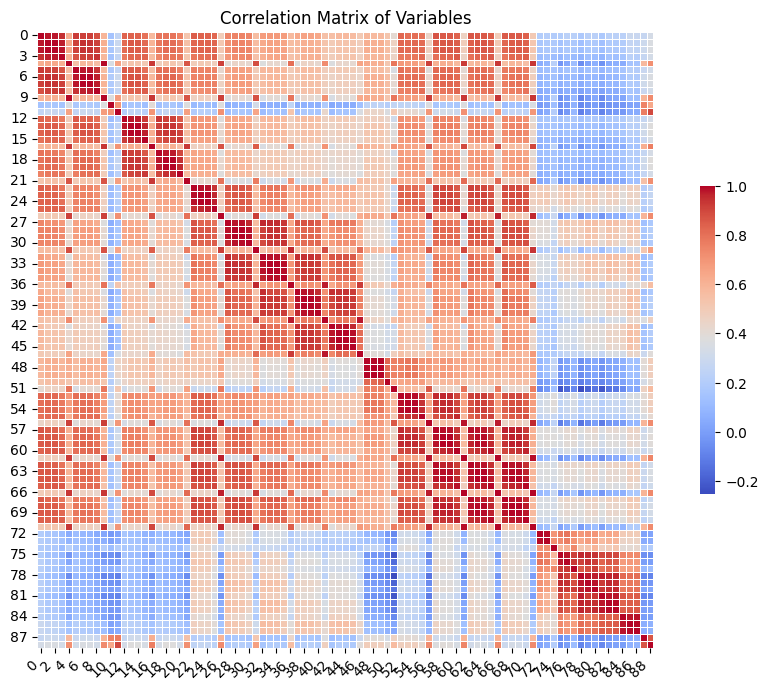

In [79]:
correlation_matrix = pd.DataFrame(x_train).corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm', 
            square=True, cbar_kws={"shrink": .5}, linewidths=.5)

# Set titles and labels
plt.title('Correlation Matrix of Variables')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Show the plot
plt.show()

From the heatmap, we can see that there are many features highly correlated, specially features using the same transformations but different similarity functions. However, we also observe that intersection length is the similarity less correlated with the rest of them. We also see that the POS n-grams are also highly correlated between them although not so much with the rest of features.

Taking this into acount we believe that some feature reduction can be performed, and this is what we will do in the next sections.

In [80]:
for index, column in enumerate(x_train_aux.columns):
    print(f"Index: {index}, Column Name: '{column}'")

Index: 0, Column Name: 'Tokens_jaccard_sim'
Index: 1, Column Name: 'Tokens_dice_sim'
Index: 2, Column Name: 'Tokens_cosine'
Index: 3, Column Name: 'Tokens_overlap'
Index: 4, Column Name: 'Tokens_intersection_length'
Index: 5, Column Name: 'Lemmas_jaccard_sim'
Index: 6, Column Name: 'Lemmas_dice_sim'
Index: 7, Column Name: 'Lemmas_cosine'
Index: 8, Column Name: 'Lemmas_overlap'
Index: 9, Column Name: 'Lemmas_intersection_length'
Index: 10, Column Name: 'Lemmas_closest_synsents_similarity_res'
Index: 11, Column Name: 'Lemmas_closest_synsents_similarity_lin'
Index: 12, Column Name: 'Entitys_jaccard_sim'
Index: 13, Column Name: 'Entitys_dice_sim'
Index: 14, Column Name: 'Entitys_cosine'
Index: 15, Column Name: 'Entitys_overlap'
Index: 16, Column Name: 'Entitys_intersection_length'
Index: 17, Column Name: 'Definitions_jaccard_sim'
Index: 18, Column Name: 'Definitions_dice_sim'
Index: 19, Column Name: 'Definitions_cosine'
Index: 20, Column Name: 'Definitions_overlap'
Index: 21, Column Name: 

**Feature Importance**

To find the most important features we have used the XGBoost Model importances since XGBoost was one of the best performant models in prior sections. XGBoost model importance is an attribute in XGBoost models that provides an array of scores representing the importance or contribution of each feature used in the model to the prediction task. This helps in understanding which features are most influential in the model's decision-making process.

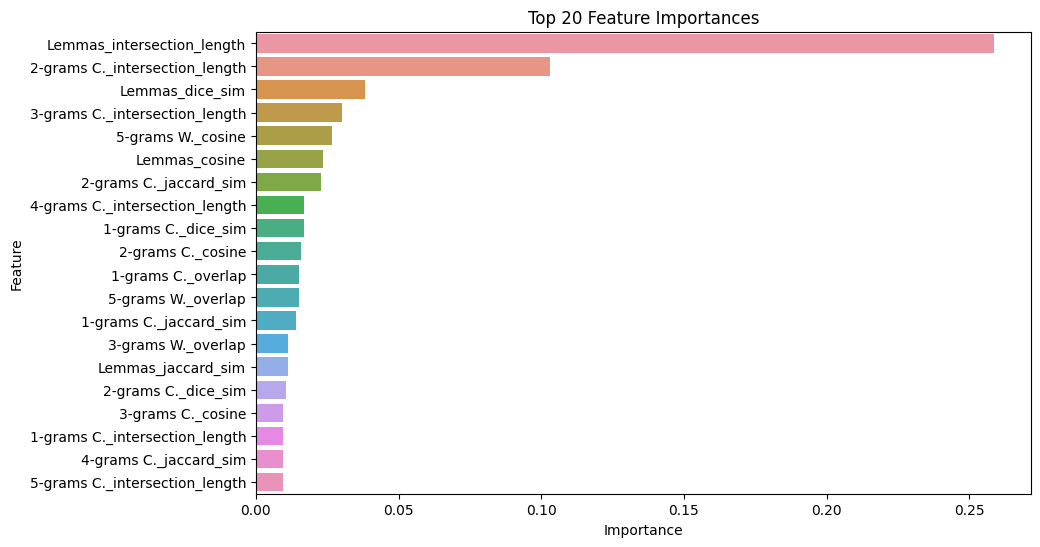

In [81]:
best_params_xgb = {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.7}

# Train an XGBoost regressor
xgb_model = xgb.XGBRegressor(**best_params_xgb, random_state=42)
xgb_model.fit(x_train, train_target)

# Get feature importances
importances = xgb_model.feature_importances_

# Get feature names (replace with your feature names)
feature_names = x_train_aux.columns  # If x_train is a pandas DataFrame

# Create a pandas series with feature importances and names
importances_series = pd.Series(importances, index=feature_names)

# Sort importances
sorted_importances = importances_series.sort_values(ascending=False)

# Number of top features to visualize
top_n = 20  # Change this to your desired number

# Select the top N features
top_features = sorted_importances.head(top_n)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title(f'Top {top_n} Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

**Train model with reduced variables**

In this section we train all models with only the top 20 features found to see if the performance is maintained.

In [82]:
x_train_red = x_train_aux[top_features.index].copy()
x_test_red = x_test_aux[top_features.index].copy()

# Initialize the StandardScaler
scaler = StandardScaler()

x_train_red.replace([np.inf, -np.inf], 0, inplace=True)
x_test_red.replace([np.inf, -np.inf], 0, inplace=True)


# Fit the scaler on the training data and transform it
x_train_red = scaler.fit_transform(x_train_red)
# Scale the test data with the same scaler
x_test_red = scaler.transform(x_test_red)

**Neural Network**

In [83]:
# Define the hyperparameter grid for tuning
param_grid = {
    'hidden_layer_sizes': [(50, 50, 50, 50), (100, 100, 100, 100), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.001, 0.01, 0.1],
    'random_state': [42]
}

# Define the MLPRegressor
mlp = MLPRegressor()

# Set up GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, cv=10, n_jobs=-1, verbose=1)

# Fit the model using GridSearchCV
grid_search.fit(x_train_red, train_target)

# After finding the best parameters with GridSearchCV

# Retrieve the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Create a new MLPRegressor instance with the best parameters
best_mlp = MLPRegressor(**best_params)

# Retrain the model on the full training set
best_mlp.fit(x_train_red, train_target)

# Make predictions on the test data
predictions = best_mlp.predict(x_test_red)

# Calculate Pearson correlation
correlation, p_value = pearsonr(predictions, test_target)

# Print the correlation coefficient
print("Pearson Correlation Coefficient after retraining: {:.4f}".format(correlation))
print("Best parameters:", best_params)

# Save the model to disk
model_path = os.path.join(models_dir, 'best_mlp_reduced.joblib')
dump(best_mlp, model_path)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Pearson Correlation Coefficient after retraining: 0.7459
Best parameters: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (50, 50, 50, 50), 'random_state': 42}


['models\\best_mlp_reduced.joblib']

**Random Forest**

In [84]:
# Define the hyperparameter grid for tuning
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [42]
}

# Define the RandomForestRegressor
rf = RandomForestRegressor()

# Set up GridSearchCV
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=10, n_jobs=-1, verbose=1)

# Fit the model using GridSearchCV
grid_search_rf.fit(x_train_red, train_target)

# After finding the best parameters with GridSearchCV

# Retrieve the best hyperparameters from the grid search
best_params_rf = grid_search_rf.best_params_

# Create a new RandomForestRegressor instance with the best parameters
best_rf = RandomForestRegressor(**best_params_rf)

# Retrain the model on the full training set
best_rf.fit(x_train_red, train_target)

# Make predictions on the test data
predictions_rf = best_rf.predict(x_test_red)

# Calculate Pearson correlation
correlation_rf, p_value = pearsonr(predictions_rf, test_target)

# Print the correlation coefficient and best parameters
print("Pearson Correlation Coefficient after retraining: {:.4f}".format(correlation_rf))
print("Best parameters:", best_params_rf)

# Save the model to disk
model_path = os.path.join(models_dir, 'best_rf_reduced.joblib')
dump(best_rf, model_path)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Pearson Correlation Coefficient after retraining: 0.7125
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 42}


['models\\best_rf_reduced.joblib']

**Support Vector Regression**

In [85]:
# Define the hyperparameter grid for tuning
param_grid_svm = {
    'C': [0.1, 1.0, 10, 100],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['rbf']
}

# Define the SVR
svm_model = SVR()

# Set up GridSearchCV
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=10, n_jobs=-1, verbose=1)

# Fit the model using GridSearchCV
grid_search_svm.fit(x_train_red, train_target)

# After finding the best parameters with GridSearchCV

# Retrieve the best hyperparameters from the grid search
best_params_svm = grid_search_svm.best_params_

# Create a new SVR instance with the best parameters
best_svm = SVR(**best_params_svm)

# Retrain the model on the full training set
best_svm.fit(x_train_red, train_target)

# Make predictions on the test data
predictions_svm = best_svm.predict(x_test_red)

# Calculate Pearson correlation
correlation_svm, p_value = pearsonr(predictions_svm, test_target)

# Print the correlation coefficient and best parameters
print("Pearson Correlation Coefficient after retraining: {:.4f}".format(correlation_svm))
print("Best parameters:", best_params_svm)

# Save the model to disk
model_path = os.path.join(models_dir, 'best_svm_reduced.joblib')
dump(best_svm, model_path)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Pearson Correlation Coefficient after retraining: 0.7368
Best parameters: {'C': 10, 'epsilon': 0.5, 'kernel': 'rbf'}


['models\\best_svm_reduced.joblib']

**XGBoost**

In [86]:
# Define the hyperparameter grid for tuning
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [5, 6, 7, 8, 9],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Define the XGBRegressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Set up GridSearchCV
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=10, n_jobs=-1, verbose=2)

# Fit the model using GridSearchCV
grid_search_xgb.fit(x_train_red, train_target)

# After finding the best parameters with GridSearchCV

# Retrieve the best hyperparameters from the grid search
best_params_xgb = grid_search_xgb.best_params_

# Create a new XGBRegressor instance with the best parameters
best_xgb = xgb.XGBRegressor(**best_params_xgb, random_state=42)

# Retrain the model on the full training set
best_xgb.fit(x_train_red, train_target)

# Make predictions on the test data
predictions_xgb = best_xgb.predict(x_test_red)

# Calculate Pearson correlation
correlation_xgb, p_value = pearsonr(predictions_xgb, test_target)

# Print the correlation coefficient and best parameters
print("Pearson Correlation Coefficient after retraining: {:.4f}".format(correlation_xgb))
print("Best parameters:", best_params_xgb)

# Save the model to disk
model_path = os.path.join(models_dir, 'best_xgb_reduced.joblib')
dump(best_xgb, model_path)

Fitting 10 folds for each of 750 candidates, totalling 7500 fits
Pearson Correlation Coefficient after retraining: 0.7154
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100, 'subsample': 0.6}


['models\\best_xgb_reduced.joblib']

**Voting Regressor**

In [87]:
# Create the voting regressor
voting_model = VotingRegressor(
    estimators=[
        ('rf', best_rf),
        ('svm', best_svm),
        ('xgb', best_xgb),
        ('mlp', best_mlp)
    ],
    weights=[1, 1, 1, 1]  # Optional: Adjust weights if necessary
)

# Fit the voting regressor
voting_model.fit(x_train, train_target)

# Make predictions with the voting regressor
predictions_voting = voting_model.predict(x_test)

# Calculate Pearson correlation for the voting regressor
correlation_voting, p_value = pearsonr(predictions_voting, test_target)

# Print the correlation coefficient
print("Pearson Correlation Coefficient (Voting Regressor): {:.4f}".format(correlation_voting))

# Save the model to disk
model_path = os.path.join(models_dir, 'voting_model_reduced.joblib')
dump(voting_model, model_path)

c:\Users\unaig\anaconda3\envs\py38ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pearson Correlation Coefficient (Voting Regressor): 0.7629


['models\\voting_model_reduced.joblib']

After training all the models, we find that the reduction in Pearson Correlation is only 0.0031. This reinforces the hypothesis that the most important features selected by XGBoost are also the most important features for the rest of the models. With this feature selection we have reduced the amount of features from 89 to 20 achieving very similar performance.

##### PCA
In this section we will see if using PCA instead of manual selection of features is helpful to further reduce the amount of features.

PCA is specially interesting in this case since we have observed that some of the features were highly correlated. With PCA we decorrelate these features while also reduce the amount of features needed.

We will select as many features needed to explain 95% of variance.

In [88]:
# Initialize PCA. You can specify how many components you want, for example:
pca = PCA(n_components=0.95)  # retains 95% of the variance

# Fit PCA on the scaled training data
x_train_pca = pca.fit_transform(x_train)

# Apply the PCA transformation to the test data
x_test_pca = pca.transform(x_test)

# Optionally convert the PCA components of both sets to DataFrames
pca_columns = ['PCA_Component_' + str(i) for i in range(1, x_train_pca.shape[1] + 1)]
x_train_pca_df = pd.DataFrame(x_train_pca, columns=pca_columns)
x_test_pca_df = pd.DataFrame(x_test_pca, columns=pca_columns[:x_test_pca.shape[1]])

**Neural Network**

In [89]:
# Define the hyperparameter grid for tuning
param_grid = {
    'hidden_layer_sizes': [(50, 50, 50, 50), (100, 100, 100, 100), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.001, 0.01, 0.1],
    'random_state': [42]
}

# Define the MLPRegressor
mlp = MLPRegressor()

# Set up GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, cv=10, n_jobs=-1, verbose=1)

# Fit the model using GridSearchCV
grid_search.fit(x_train_pca_df, train_target)

# After finding the best parameters with GridSearchCV

# Retrieve the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Create a new MLPRegressor instance with the best parameters
best_mlp = MLPRegressor(**best_params)

# Retrain the model on the full training set
best_mlp.fit(x_train_pca_df, train_target)

# Make predictions on the test data
predictions = best_mlp.predict(x_test_pca_df)

# Calculate Pearson correlation
correlation, p_value = pearsonr(predictions, test_target)

# Print the correlation coefficient
print("Pearson Correlation Coefficient after retraining: {:.4f}".format(correlation))
print("Best parameters:", best_params)

# Save the model to disk
model_path = os.path.join(models_dir, 'best_mlp_pca.joblib')
dump(best_mlp, model_path)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


c:\Users\unaig\anaconda3\envs\py38ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pearson Correlation Coefficient after retraining: 0.6866
Best parameters: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (100, 50), 'random_state': 42}


c:\Users\unaig\anaconda3\envs\py38ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


['models\\best_mlp_pca.joblib']

**Random Forest**

In [90]:
# Define the hyperparameter grid for tuning
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [42]
}

# Define the RandomForestRegressor
rf = RandomForestRegressor()

# Set up GridSearchCV
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=10, n_jobs=-1, verbose=1)

# Fit the model using GridSearchCV
grid_search_rf.fit(x_train_pca_df, train_target)

# After finding the best parameters with GridSearchCV

# Retrieve the best hyperparameters from the grid search
best_params_rf = grid_search_rf.best_params_

# Create a new RandomForestRegressor instance with the best parameters
best_rf = RandomForestRegressor(**best_params_rf)

# Retrain the model on the full training set
best_rf.fit(x_train_pca_df, train_target)

# Make predictions on the test data
predictions_rf = best_rf.predict(x_test_pca_df)

# Calculate Pearson correlation
correlation_rf, p_value = pearsonr(predictions_rf, test_target)

# Print the correlation coefficient and best parameters
print("Pearson Correlation Coefficient after retraining: {:.4f}".format(correlation_rf))
print("Best parameters:", best_params_rf)

# Save the model to disk
model_path = os.path.join(models_dir, 'best_rf_pca.joblib')
dump(best_rf, model_path)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Pearson Correlation Coefficient after retraining: 0.7182
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}


['models\\best_rf_pca.joblib']

**Support Vector Regression**

In [91]:
# Define the hyperparameter grid for tuning
param_grid_svm = {
    'C': [0.1, 1.0, 10, 100],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['rbf']
}

# Define the SVR
svm_model = SVR()

# Set up GridSearchCV
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=10, n_jobs=-1, verbose=1)

# Fit the model using GridSearchCV
grid_search_svm.fit(x_train_pca_df, train_target)

# After finding the best parameters with GridSearchCV

# Retrieve the best hyperparameters from the grid search
best_params_svm = grid_search_svm.best_params_

# Create a new SVR instance with the best parameters
best_svm = SVR(**best_params_svm)

# Retrain the model on the full training set
best_svm.fit(x_train_pca_df, train_target)

# Make predictions on the test data
predictions_svm = best_svm.predict(x_test_pca_df)

# Calculate Pearson correlation
correlation_svm, p_value = pearsonr(predictions_svm, test_target)

# Print the correlation coefficient and best parameters
print("Pearson Correlation Coefficient after retraining: {:.4f}".format(correlation_svm))
print("Best parameters:", best_params_svm)

# Save the model to disk
model_path = os.path.join(models_dir, 'best_svm_pca.joblib')
dump(best_svm, model_path)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Pearson Correlation Coefficient after retraining: 0.7212
Best parameters: {'C': 10, 'epsilon': 0.5, 'kernel': 'rbf'}


['models\\best_svm_pca.joblib']

**XGBoost**

In [92]:
# Define the hyperparameter grid for tuning
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [5, 6, 7, 8, 9],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Define the XGBRegressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Set up GridSearchCV
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=10, n_jobs=-1, verbose=2)

# Fit the model using GridSearchCV
grid_search_xgb.fit(x_train_pca_df, train_target)

# After finding the best parameters with GridSearchCV

# Retrieve the best hyperparameters from the grid search
best_params_xgb = grid_search_xgb.best_params_

# Create a new XGBRegressor instance with the best parameters
best_xgb = xgb.XGBRegressor(**best_params_xgb, random_state=42)

# Retrain the model on the full training set
best_xgb.fit(x_train_pca_df, train_target)

# Make predictions on the test data
predictions_xgb = best_xgb.predict(x_test_pca_df)

# Calculate Pearson correlation
correlation_xgb, p_value = pearsonr(predictions_xgb, test_target)

# Print the correlation coefficient and best parameters
print("Pearson Correlation Coefficient after retraining: {:.4f}".format(correlation_xgb))
print("Best parameters:", best_params_xgb)

# Save the model to disk
model_path = os.path.join(models_dir, 'best_xgb_pca.joblib')
dump(best_xgb, model_path)

Fitting 10 folds for each of 750 candidates, totalling 7500 fits
Pearson Correlation Coefficient after retraining: 0.7139
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100, 'subsample': 0.7}


['models\\best_xgb_pca.joblib']

**Voting Regressor**

In [93]:
# Create the voting regressor
voting_model = VotingRegressor(
    estimators=[
        ('rf', best_rf),
        ('svm', best_svm),
        ('xgb', best_xgb),
        ('mlp', best_mlp)
    ],
    weights=[1, 1, 1, 1]  # Optional: Adjust weights if necessary
)

# Fit the voting regressor
voting_model.fit(x_train, train_target)

# Make predictions with the voting regressor
predictions_voting = voting_model.predict(x_test)

# Calculate Pearson correlation for the voting regressor
correlation_voting, p_value = pearsonr(predictions_voting, test_target)

# Print the correlation coefficient
print("Pearson Correlation Coefficient (Voting Regressor): {:.4f}".format(correlation_voting))

# Save the model to disk
model_path = os.path.join(models_dir, 'voting_model_pca.joblib')
dump(voting_model, model_path)

Pearson Correlation Coefficient (Voting Regressor): 0.7676


['models\\voting_model_pca.joblib']

After training the models with the PCA dataset, we obtain an increase of 0.001 from our best results so far, with a reduction from 89 to only 12 features.

Although now the features are not as easy to understand as with the manual feature selection (they are now a linear combination of features), we were able to further reduce the amount of features needed while enhancing the performance of the model.

#### Using Data Augmentation and PCA

In the final section, we will try to further enhance the performance of our best model (All features + PCA) using data augmentation. The data augmentation was done by translating the sentence pairs to Spanish and then back to English, obtaining similar sentences to the original ones but slightly paraphrased.

In [94]:
x_train_augmented_aux = x_train_augmented.copy()
train_target_augmented = pd.concat([train_target, train_target], ignore_index=True)

# Initialize the StandardScaler
scaler = StandardScaler()
x_train_augmented.replace([np.inf, -np.inf], 0, inplace=True)
# Fit the scaler on the training data and transform it
x_train_augmented = scaler.fit_transform(x_train_augmented)

In [95]:
# Initialize PCA. You can specify how many components you want, for example:
pca = PCA(n_components=0.95)  # retains 95% of the variance

# Fit PCA on the scaled training data
x_train_pca = pca.fit_transform(x_train_augmented)

# Apply the PCA transformation to the test data
x_test_pca = pca.transform(x_test)

# Optionally convert the PCA components of both sets to DataFrames
pca_columns = ['PCA_Component_' + str(i) for i in range(1, x_train_pca.shape[1] + 1)]
x_train_pca_df = pd.DataFrame(x_train_pca, columns=pca_columns)
x_test_pca_df = pd.DataFrame(x_test_pca, columns=pca_columns[:x_test_pca.shape[1]])

**Neural Network**

In [96]:
# Define the hyperparameter grid for tuning
param_grid = {
    'hidden_layer_sizes': [(50, 50, 50, 50), (100, 100, 100, 100), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.001, 0.01, 0.1],
    'random_state': [42]
}

# Define the MLPRegressor
mlp = MLPRegressor()

# Set up GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, cv=10, n_jobs=-1, verbose=1)

# Fit the model using GridSearchCV
grid_search.fit(x_train_pca_df, train_target_augmented)

# After finding the best parameters with GridSearchCV

# Retrieve the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Create a new MLPRegressor instance with the best parameters
best_mlp = MLPRegressor(**best_params)

# Retrain the model on the full training set
best_mlp.fit(x_train_pca_df, train_target_augmented)

# Make predictions on the test data
predictions = best_mlp.predict(x_test_pca_df)

# Calculate Pearson correlation
correlation, p_value = pearsonr(predictions, test_target)

# Print the correlation coefficient
print("Pearson Correlation Coefficient after retraining: {:.4f}".format(correlation))
print("Best parameters:", best_params)

# Save the model to disk
model_path = os.path.join(models_dir, 'best_mlp_pca_augmented.joblib')
dump(best_mlp, model_path)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Pearson Correlation Coefficient after retraining: 0.7242
Best parameters: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (100, 50), 'random_state': 42}


['models\\best_mlp_pca_augmented.joblib']

**Random Forest**

In [97]:
# Define the hyperparameter grid for tuning
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [42]
}

# Define the RandomForestRegressor
rf = RandomForestRegressor()

# Set up GridSearchCV
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=10, n_jobs=-1, verbose=1)

# Fit the model using GridSearchCV
grid_search_rf.fit(x_train_pca_df, train_target_augmented)

# After finding the best parameters with GridSearchCV

# Retrieve the best hyperparameters from the grid search
best_params_rf = grid_search_rf.best_params_

# Create a new RandomForestRegressor instance with the best parameters
best_rf = RandomForestRegressor(**best_params_rf)

# Retrain the model on the full training set
best_rf.fit(x_train_pca_df, train_target_augmented)

# Make predictions on the test data
predictions_rf = best_rf.predict(x_test_pca_df)

# Calculate Pearson correlation
correlation_rf, p_value = pearsonr(predictions_rf, test_target)

# Print the correlation coefficient and best parameters
print("Pearson Correlation Coefficient after retraining: {:.4f}".format(correlation_rf))
print("Best parameters:", best_params_rf)

# Save the model to disk
model_path = os.path.join(models_dir, 'best_rf_pca_augmented.joblib')
dump(best_rf, model_path)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Pearson Correlation Coefficient after retraining: 0.7220
Best parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 42}


['models\\best_rf_pca_augmented.joblib']

**Support Vector Regression**

In [98]:
# Define the hyperparameter grid for tuning
param_grid_svm = {
    'C': [0.1, 1.0, 10, 100],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['rbf']
}

# Define the SVR
svm_model = SVR()

# Set up GridSearchCV
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=10, n_jobs=-1, verbose=1)

# Fit the model using GridSearchCV
grid_search_svm.fit(x_train_pca_df, train_target_augmented)

# After finding the best parameters with GridSearchCV

# Retrieve the best hyperparameters from the grid search
best_params_svm = grid_search_svm.best_params_

# Create a new SVR instance with the best parameters
best_svm = SVR(**best_params_svm)

# Retrain the model on the full training set
best_svm.fit(x_train_pca_df, train_target_augmented)

# Make predictions on the test data
predictions_svm = best_svm.predict(x_test_pca_df)

# Calculate Pearson correlation
correlation_svm, p_value = pearsonr(predictions_svm, test_target)

# Print the correlation coefficient and best parameters
print("Pearson Correlation Coefficient after retraining: {:.4f}".format(correlation_svm))
print("Best parameters:", best_params_svm)

# Save the model to disk
model_path = os.path.join(models_dir, 'best_svm_pca_augmented.joblib')
dump(best_svm, model_path)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Pearson Correlation Coefficient after retraining: 0.6941
Best parameters: {'C': 100, 'epsilon': 0.5, 'kernel': 'rbf'}


['models\\best_svm_pca_augmented.joblib']

**XGBoost**

In [99]:
# Define the hyperparameter grid for tuning
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [5, 6, 7, 8, 9],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Define the XGBRegressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Set up GridSearchCV
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=10, n_jobs=-1, verbose=2)

# Fit the model using GridSearchCV
grid_search_xgb.fit(x_train_pca_df, train_target_augmented)

# After finding the best parameters with GridSearchCV

# Retrieve the best hyperparameters from the grid search
best_params_xgb = grid_search_xgb.best_params_

# Create a new XGBRegressor instance with the best parameters
best_xgb = xgb.XGBRegressor(**best_params_xgb, random_state=42)

# Retrain the model on the full training set
best_xgb.fit(x_train_pca_df, train_target_augmented)

# Make predictions on the test data
predictions_xgb = best_xgb.predict(x_test_pca_df)

# Calculate Pearson correlation
correlation_xgb, p_value = pearsonr(predictions_xgb, test_target)

# Print the correlation coefficient and best parameters
print("Pearson Correlation Coefficient after retraining: {:.4f}".format(correlation_xgb))
print("Best parameters:", best_params_xgb)

# Save the model to disk
model_path = os.path.join(models_dir, 'best_xgb_pca_augmented.joblib')
dump(best_xgb, model_path)

Fitting 10 folds for each of 750 candidates, totalling 7500 fits
Pearson Correlation Coefficient after retraining: 0.7134
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100, 'subsample': 0.9}


['models\\best_xgb_pca_augmented.joblib']

**Voting Regressor**

In [100]:
# Create the voting regressor
voting_model = VotingRegressor(
    estimators=[
        ('rf', best_rf),
        ('svm', best_svm),
        ('xgb', best_xgb),
        ('mlp', best_mlp)
    ],
    weights=[1, 1, 1, 1]  # Optional: Adjust weights if necessary
)

# Fit the voting regressor
voting_model.fit(x_train, train_target)

# Make predictions with the voting regressor
predictions_voting = voting_model.predict(x_test)

# Calculate Pearson correlation for the voting regressor
correlation_voting, p_value = pearsonr(predictions_voting, test_target)

# Print the correlation coefficient
print("Pearson Correlation Coefficient (Voting Regressor): {:.4f}".format(correlation_voting))

# Save the model to disk
model_path = os.path.join(models_dir, 'voting_model_pca_augmented.joblib')
dump(voting_model, model_path)

Pearson Correlation Coefficient (Voting Regressor): 0.7635


['models\\voting_model_pca_augmented.joblib']

After training the models we observe that the performance of the agumented model does not improve the standard one. This could be because of the method used to augment data. On one hand, if translation is very accurate, we will obtain very similar pairs of sentences to the ones in the standard dataset. On the other hand, if the translation is not very accurate it can introduce noise that affects performance.

---
### Conclusions

In this study, we have successfully developed and implemented a comprehensive system designed to detect paraphrasing by evaluating sentence similarity.

The process began with the implementation of robust preprocessing strategies, aimed at minimizing errors in text data, thereby laying a strong foundation for accurate analysis. A part from the techniques learned in class we have used a spell checker to ensure there were no spelling errors.

Subsequently, we developed a diverse array of features. These features were meticulously crafted to capture both lexical and syntactic dimensions of the text, supplemented by multiple similarity functions.

A key aspect of our approach was the application of various machine learning methods. These methods were chosen to effectively make use the potential of the generated features, outputing a sophisticated sentence similarity value.

Throughout our exploration, we observed a notable impact of lexical and syntactic features on the performance of our models. It became evident that lexical features, with their inherent ability to convey meaning, were more influential compared to syntactic features in the context of paraphrase detection.

Feature reduction methods were a significant component of our methodology, particularly Principal Component Analysis (PCA). The application of PCA not only streamlined our feature set but also enhanced the overall performance of our models.

Lastly, we tried data augmentation, although very interesting, it did not yield the anticipated improvement in results.

In summary, our work demonstrates the challenges involved in detecting paraphrasing through sentence similarity metrics.

Finally, we display the performance of our different models in the following table:

| Model           | Correlation | Features |
|-----------------|-------------|----------|
| Lexical         | 0.7567      | 74       |
| Syntactic       | 0.6572      | 44       |
| Complete        | 0.7666      | 89       |
| Manual Selection| 0.7629      | 20       |
| PCA             | 0.7676      | 12       |
| PCA Augmented   | 0.7635      | 12       |

---
## Biblography

Šarić, F., Glavaš, G., Karan, M., Šnajder, J., & Bašić, B. D. (2012). Takelab: Systems for measuring semantic text similarity. In * SEM 2012: The First Joint Conference on Lexical and Computational Semantics–Volume 1: Proceedings of the main conference and the shared task, and Volume 2: Proceedings of the Sixth International Workshop on Semantic Evaluation (SemEval 2012) (pp. 441-448).


Bär, D., Biemann, C., Gurevych, I., & Zesch, T. (2012). Ukp: Computing semantic textual similarity by combining multiple content similarity measures. In * SEM 2012: The First Joint Conference on Lexical and Computational Semantics–Volume 1: Proceedings of the main conference and the shared task, and Volume 2: Proceedings of the Sixth International Workshop on Semantic Evaluation (SemEval 2012) (pp. 435-440).